#  Because of the length of the dataset, a reduction in size by means of feature engineering and selection is necessary.**
**Part 1 will consist of selecting certain features based on their predictive power of future values generated by the sensor**
**Part 2 will consist of extracting these features from the whole dataset and concatenating them into a new dataset**
! Due to high computational cost, the procedure will only be demonstrated for a single sensor reading

## Part 1

In [2]:
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 30)  # Display up to 10 rows
pd.set_option('display.max_columns', 40) # Display up to 10 rows
pd.set_option('display.width', 50)


df = pd.read_csv("C:\\Users\\JoshuaBraun\\Downloads\\Bamberg_DE1.csv", nrows=200000 ,delimiter=";", decimal=",")
new_column_names_for_readability = ["ms_since_start",
                                    "DW01_velocity","DW01_position","DW01_Difference","DW01_Torque",
                                    "DW03_velocity","DW03_position","DW03_Difference","DW03_Torque",
                                    "DW05_velocity","DW05_position","DW05_Difference","DW05_Torque",
                                    "DW07_velocity","DW07_position","DW07_Difference","DW07_Torque"]
df.columns=new_column_names_for_readability


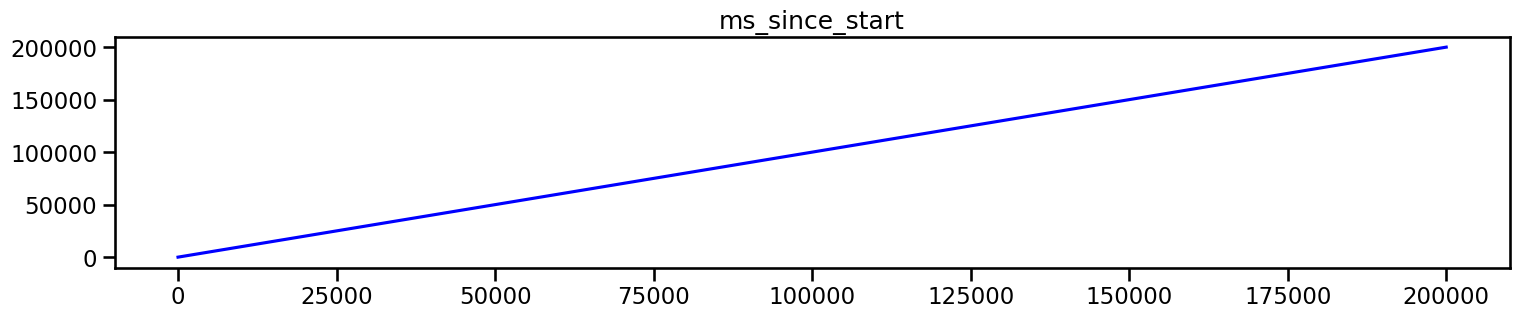

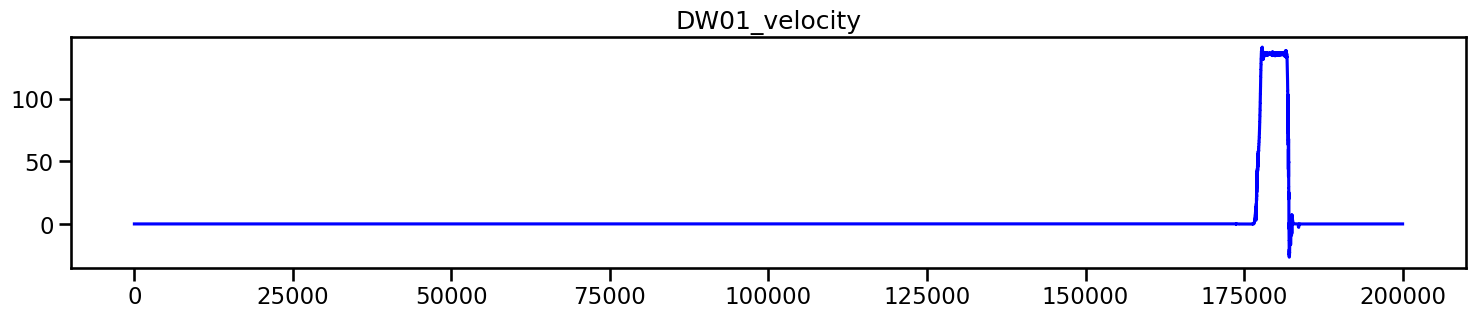

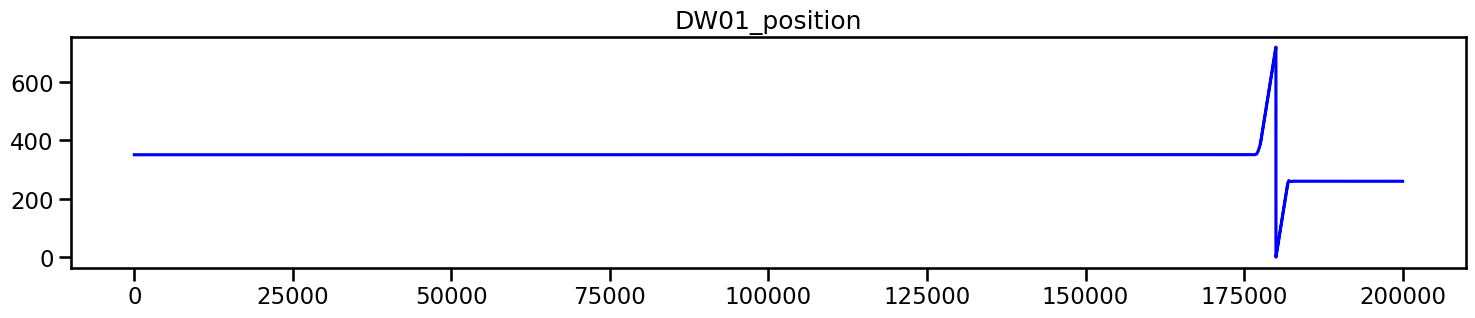

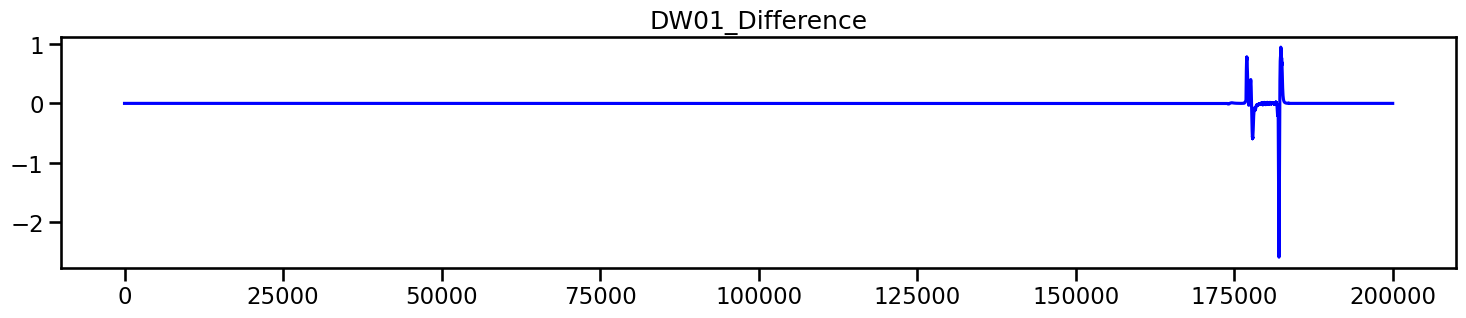

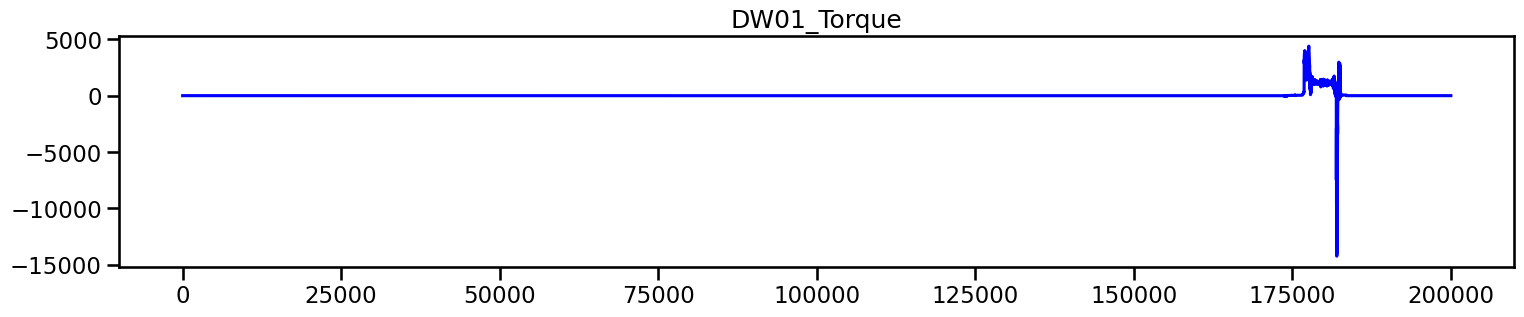

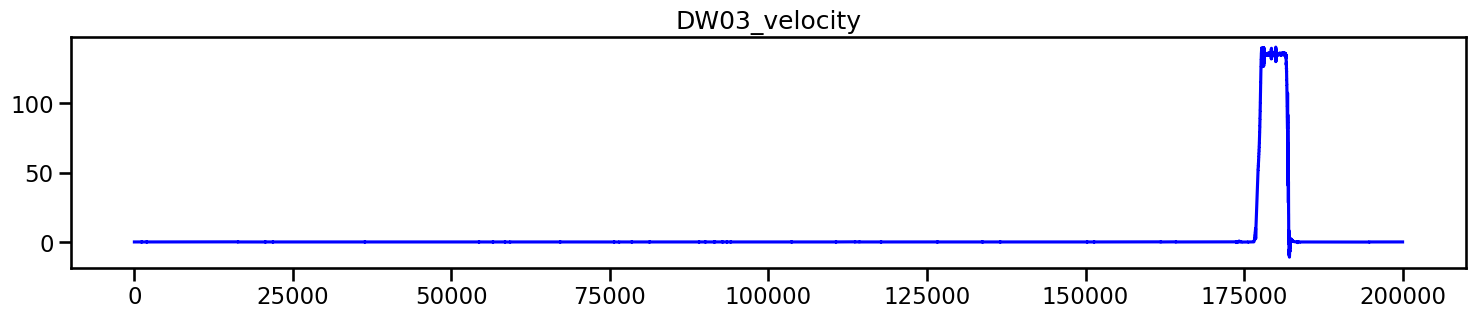

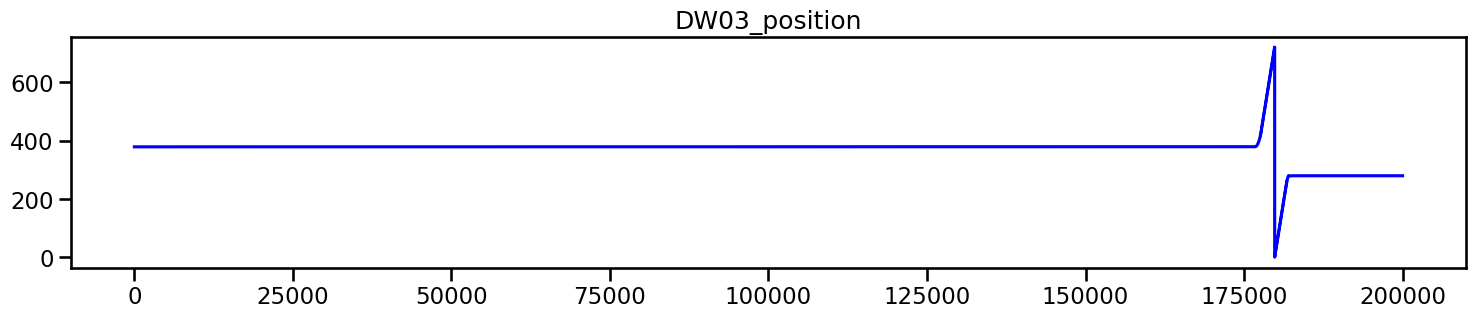

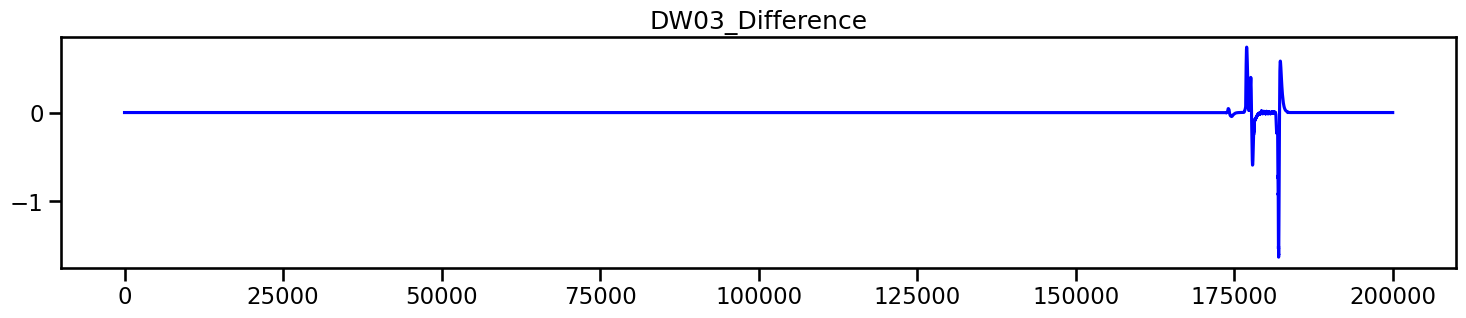

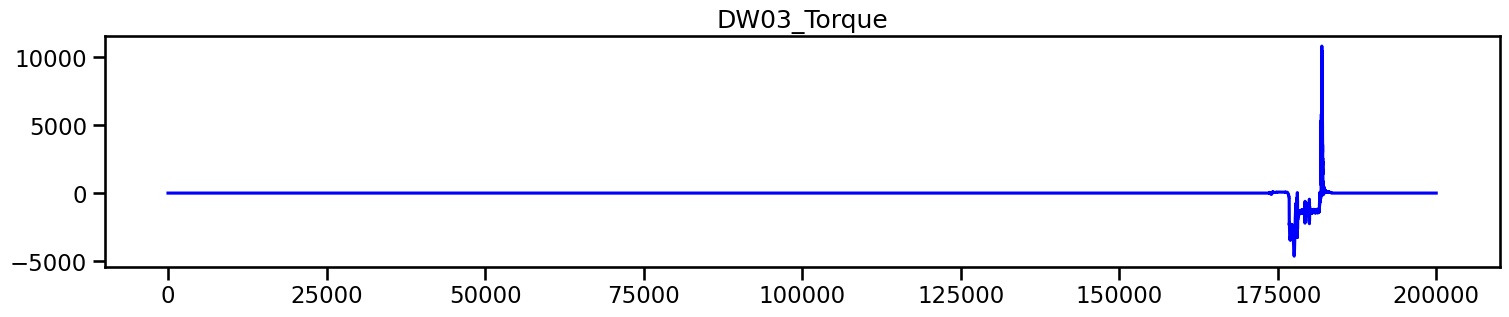

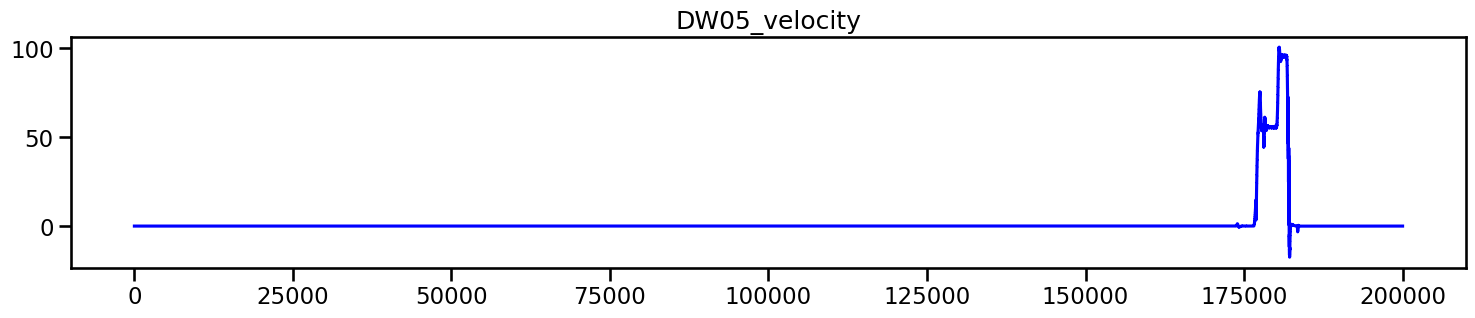

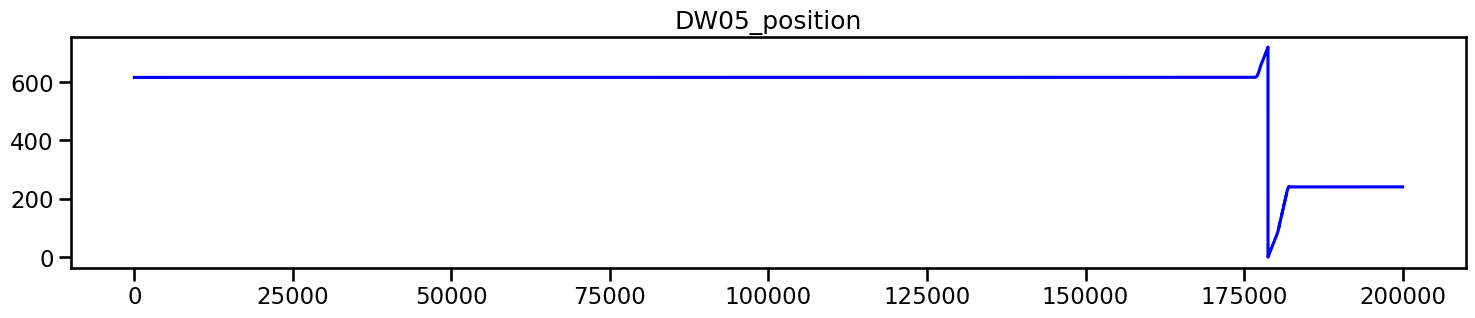

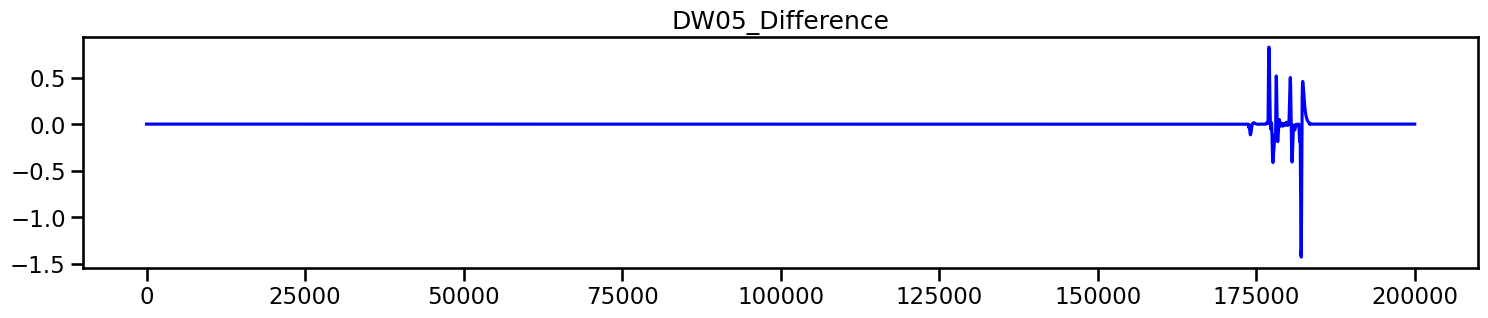

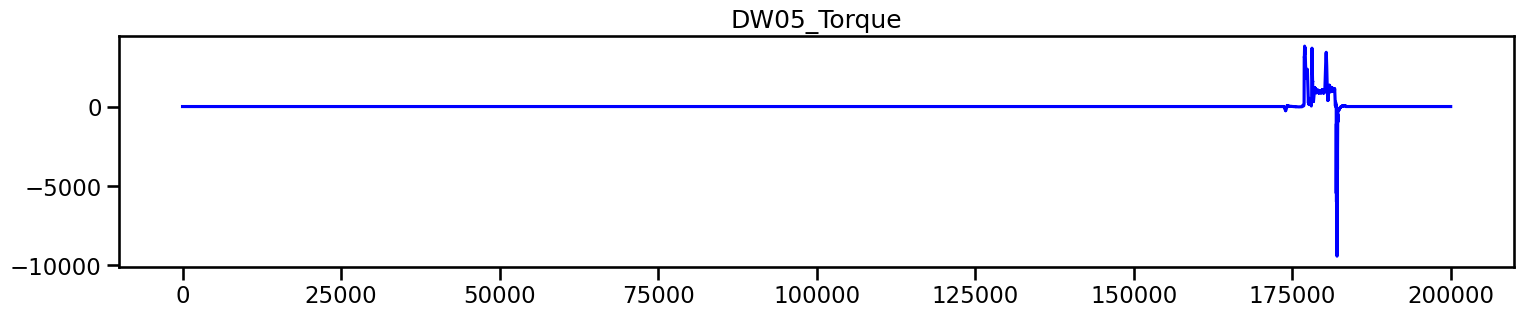

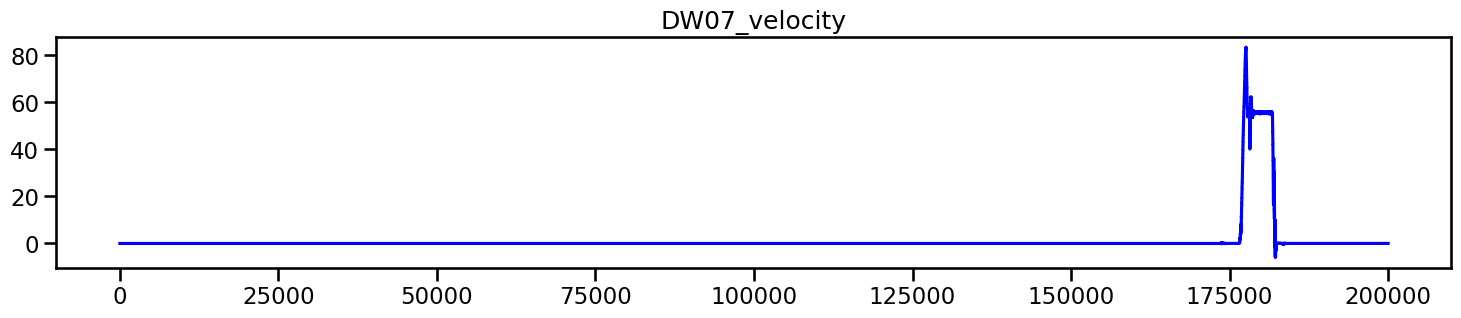

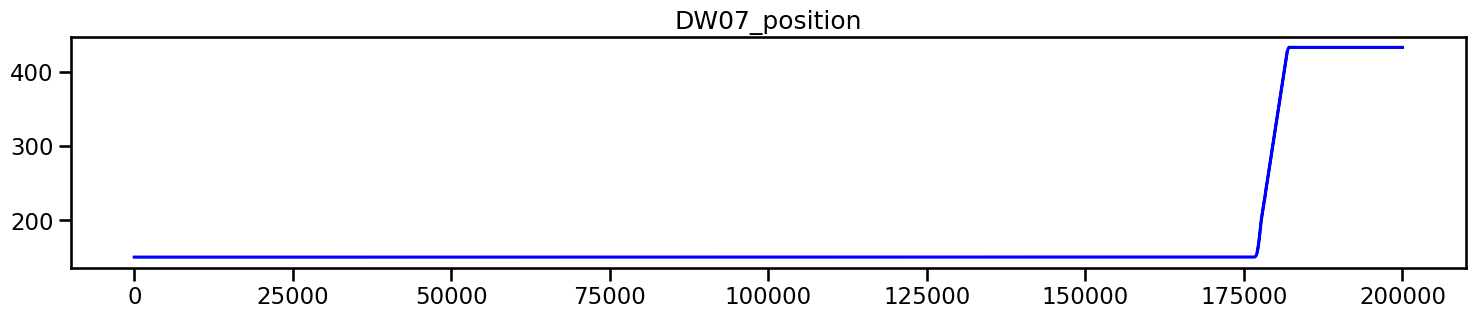

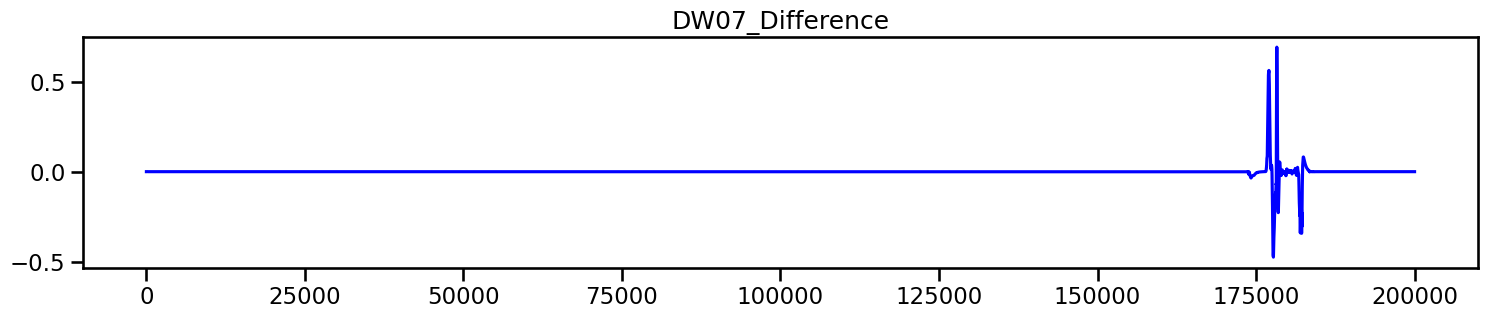

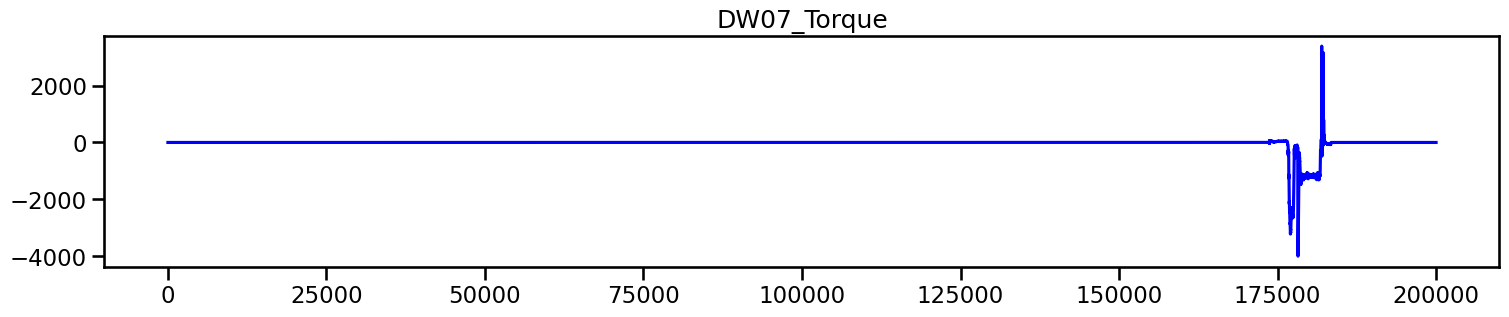

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
names=df.columns
# Plot time series for each sensor with BROKEN state marked with X in red color
for name in names:
    sns.set_context('talk')
    _ = plt.figure(figsize=(18,3))
    _ = plt.plot(df[name], color='blue')
    _ = plt.title(name)
    plt.show()

array([[<Axes: title={'center': 'ms_since_start'}>,
        <Axes: title={'center': 'DW01_velocity'}>,
        <Axes: title={'center': 'DW01_position'}>,
        <Axes: title={'center': 'DW01_Difference'}>],
       [<Axes: title={'center': 'DW01_Torque'}>,
        <Axes: title={'center': 'DW03_velocity'}>,
        <Axes: title={'center': 'DW03_position'}>,
        <Axes: title={'center': 'DW03_Difference'}>],
       [<Axes: title={'center': 'DW03_Torque'}>,
        <Axes: title={'center': 'DW05_velocity'}>,
        <Axes: title={'center': 'DW05_position'}>,
        <Axes: title={'center': 'DW05_Difference'}>],
       [<Axes: title={'center': 'DW05_Torque'}>,
        <Axes: title={'center': 'DW07_velocity'}>,
        <Axes: title={'center': 'DW07_position'}>,
        <Axes: title={'center': 'DW07_Difference'}>],
       [<Axes: title={'center': 'DW07_Torque'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

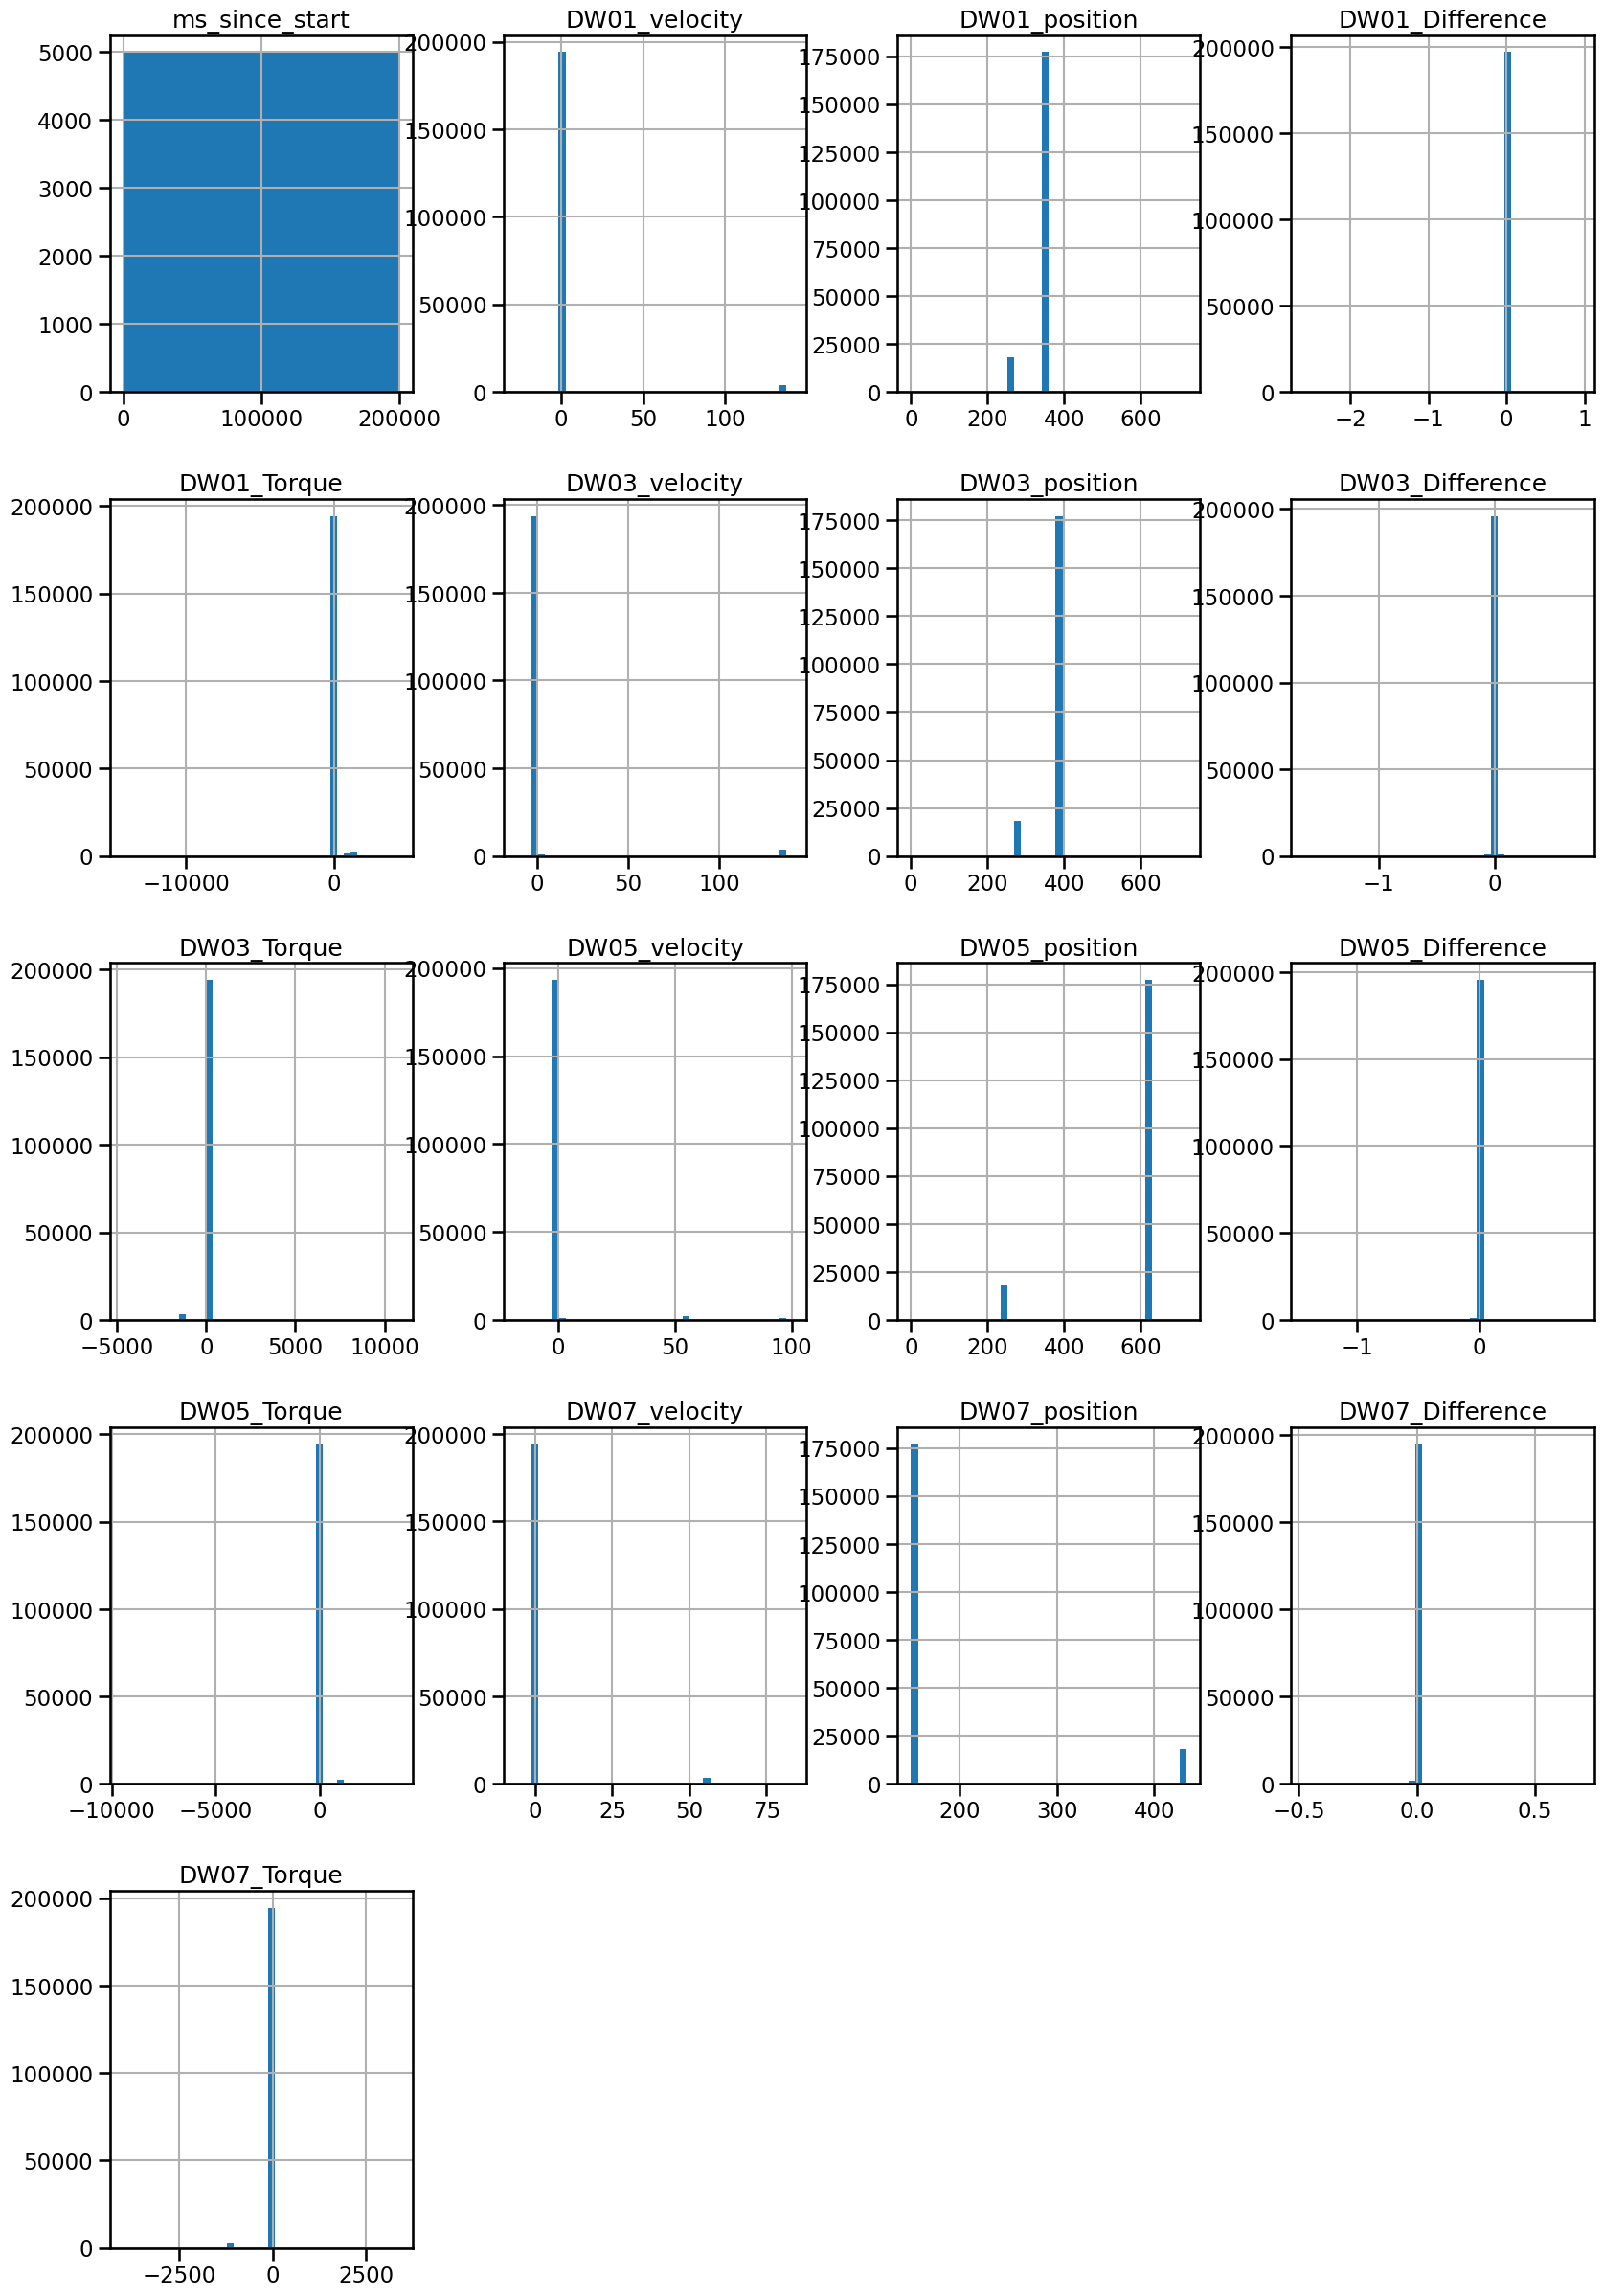

In [4]:
df.hist(bins=40, figsize=(20,30))

<Axes: >

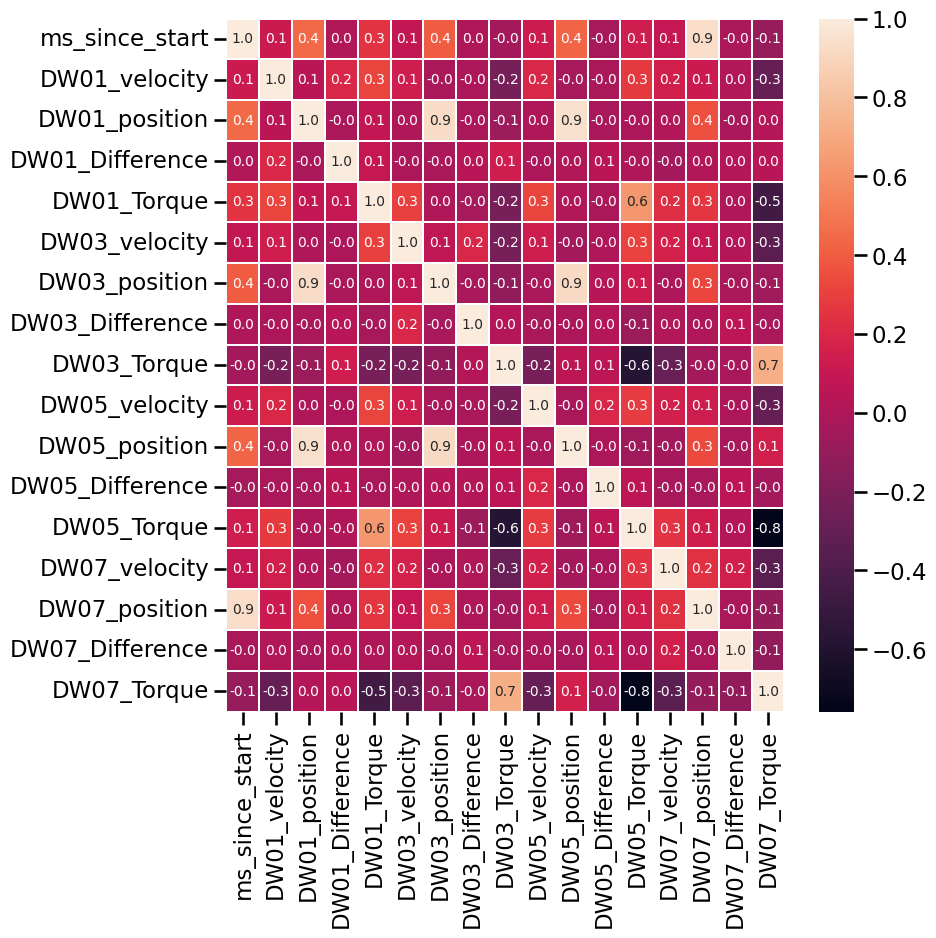

In [5]:
plt.figure(figsize=(9,9)) # check for highly correlated data, as it will likely not contain much new information
sns.heatmap(df.corr(method="spearman"), annot=True, linewidth=.2,fmt=".1f",annot_kws={"size":10}) # the data is far from normally distributed

This sample of the data will be used to generate and select the features required for the transformation of the entire dataset in part 2

In [6]:
#Generate a dataframe containing the rolling windows
df_rolling_win = pd.DataFrame()
rolling_window_size = 12000  # Size of the rolling window
df_rolling_targets = pd.DataFrame()
rolling_target_size = 2000 #size of the target

def custom_window(col_to_pass, window_size, target_size):
    n = len(col_to_pass)
    value_list=[]
    for i in range(0, n-window_size, target_size):
        for val in col_to_pass[i:i+window_size]:
            value_list.append(val)
    return value_list

# Apply rolling window to each column
for col in df.columns:
    df_rolling_win[f'{col}_rolling_win'] = custom_window(df[col], rolling_window_size, rolling_target_size)

#Grouping index
repeat_values = df_rolling_win.index // 12000

# Create a new column and assign the repeating values to it
df_rolling_win['grouping'] = repeat_values

In [7]:

def custom_target_window(col_to_pass, window_size, target_size):
    n = len(col_to_pass)
    return [col_to_pass[i+window_size:i+window_size+target_size] for i in range(0, n, target_size)]

# Apply rolling window to each column
for col in df.columns:
    df_rolling_targets[f'{col}_rolling_targets'] = custom_target_window(df[col], rolling_window_size, rolling_target_size)

In [8]:
#Fitting the length of the frame
df_rolling_targets = df_rolling_targets.iloc[:np.max(repeat_values)+1,:]


For every vector of target variables, certain target features will be calculated.

In [9]:
def range_of_vals(x, axis=0):
    return np.max(x, axis=axis) - np.min(x, axis=axis)

del df_rolling_targets["ms_since_start_rolling_targets"]
df_rolling_targets_features = pd.DataFrame()

for col in df_rolling_targets.columns:
    df_rolling_targets_features[f"{col}_mean"]   = df_rolling_targets[col].apply(np.mean)
    df_rolling_targets_features[f"{col}_std"]    = df_rolling_targets[col].apply(np.std)
    df_rolling_targets_features[f"{col}_max"]    = df_rolling_targets[col].apply(np.max)
    df_rolling_targets_features[f"{col}_min"]    = df_rolling_targets[col].apply(np.min)
    df_rolling_targets_features[f"{col}_range"]  = df_rolling_targets[col].apply(range_of_vals)

In [10]:
'''
#optional:
names = df_rolling_targets_features.columns
for name in names:
    sns.set_context('talk')
    _ = plt.figure(figsize=(18,3))
    _ = plt.plot(df_rolling_targets_features[name], color='blue')
    _ = plt.title(name)
    plt.show()
'''

"\n#optional:\nnames = df_rolling_targets_features.columns\nfor name in names:\n    sns.set_context('talk')\n    _ = plt.figure(figsize=(18,3))\n    _ = plt.plot(df_rolling_targets_features[name], color='blue')\n    _ = plt.title(name)\n    plt.show()\n"

In [11]:
df_rolling_targets_features["DW01_velocity_rolling_targets_mean"].nunique() #unique values for our single sensor selection target window

21

In [12]:
#testing the functionality of ts.fresh for the rolling windows of a single sensor
!pip install tsfresh
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
fcp_settings = EfficientFCParameters() #will yield a list of computationally cheap features to extract
test_frame = pd.DataFrame()
test_frame["velocity"], test_frame["grouping"] = df_rolling_win["DW01_velocity_rolling_win"],df_rolling_win["grouping"]
extracted_features = extract_features(test_frame, column_id="grouping", default_fc_parameters=fcp_settings)



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: C:\Users\JoshuaBraun\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
Feature Extraction: 100%|██████████| 19/19 [03:04<00:00,  9.69s/it]


In [13]:
from tsfresh import select_features
from tsfresh.feature_selection.relevance import calculate_relevance_table
from tsfresh.utilities.dataframe_functions import impute
impute(extracted_features)
y_vec = df_rolling_targets_features["DW01_velocity_rolling_targets_mean"]
selected = select_features(extracted_features,y_vec)
print(selected)

C:\Users\JoshuaBraun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['velocity__friedrich_coefficients__coeff_0__m_3__r_30'
 'velocity__friedrich_coefficients__coeff_1__m_3__r_30'
 'velocity__friedrich_coefficients__coeff_2__m_3__r_30'
 'velocity__friedrich_coefficients__coeff_3__m_3__r_30'
 'velocity__max_langevin_fixed_point__m_3__r_30'
 'velocity__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


    velocity__large_standard_deviation__r_0.1   
0                                         0.0  \
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   
..                                        ...   
89                                        1.0   
90                                        1.0   
91                                        0.0   
92                                        1.0   
93                                        0.0   

    velocity__symmetry_looking__r_0.05   
0                                  1.0  \
1                                  1.0   
2                                  1.0   
3                                  1.0   
4                                  1.0   
..                                 ...   
89                                 0.0   
90                                 0.0   
91                               

A pre-selection of features was generated. Now, we will further narrow down selection by keeping the n most significant features
as well as discarding of features showing strong linear correlations with features that were already selected

In [14]:
from tsfresh.feature_selection.relevance import calculate_relevance_table
from IPython.display import display, HTML



def eliminate_correlated_features(feature_frame,y_array, n_features, corr_method = "spearman"):
    drop_off_list = list()
    drop_off_p = list()
    relevance_table = calculate_relevance_table(feature_frame,y_array) #create relevance_table dataframe
    momentary_feature = relevance_table.iloc[0,0] #select the first feature as the most important one
    drop_off_list.append(momentary_feature) #add to list
    drop_off_p.append(relevance_table[relevance_table["feature"]==momentary_feature].iloc[0,2]) #add_p value to list
    while len(drop_off_list) < n_features: # iterate for n_features
        for feature_name in relevance_table.iloc[:,0]: #extract vector containing all feature names (including the momentary_feature)
            if abs(feature_frame[momentary_feature].corr(feature_frame[feature_name], method = corr_method)) > 0.8: #calculate correlation for all
                # features and if it exceeds .8
                relevance_table.drop(relevance_table.index[(relevance_table["feature"]==feature_name)], axis=0, inplace=True) #drop row containing feature from frame
                #print(relevance_table.iloc[0,0])
        try:
            momentary_feature = relevance_table.iloc[0,0] #pick upper-most remaining feature to add to list
            drop_off_list.append(momentary_feature)
            drop_off_p.append(relevance_table[relevance_table["feature"]==momentary_feature].iloc[0,2])
        except IndexError:
            print(f"Elimination was stopped before {n_features} could be extracted, because the weren't any left. {len(drop_off_list)} were chosen instead")
            return feature_frame[drop_off_list] , drop_off_p
            
    return feature_frame[drop_off_list] , drop_off_p

pruned_frame, p_vals= eliminate_correlated_features(selected,y_vec,50)
print(pruned_frame)

Elimination was stopped before 50 could be extracted, because the weren't any left. 45 were chosen instead
    velocity__large_standard_deviation__r_0.1   
0                                         0.0  \
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   
..                                        ...   
89                                        1.0   
90                                        1.0   
91                                        0.0   
92                                        1.0   
93                                        0.0   

    velocity__fft_coefficient__attr_"abs"__coeff_4   
0                                         0.009532  \
1                                         0.022203   
2                                         0.010542   
3                                         0.009687   
4                                 

Furthermore, recursive feature selection can be used to select only the most important features

In [15]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# choose the model to conduct the importance estimation
regressor = RandomForestRegressor(n_estimators=100, max_depth=10)
# here we want only 5 final feature, we do this to produce a ranking
n_features_to_select = 5
rfe = RFE(regressor, n_features_to_select=n_features_to_select)
rfe.fit(pruned_frame , y_vec)

# now print out the features in order of ranking
from operator import itemgetter
features = pruned_frame.columns.to_list()
for x, y in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):
    print(x, y)

1 velocity__ar_coefficient__coeff_6__k_10
1 velocity__fft_coefficient__attr_"abs"__coeff_35
1 velocity__fft_coefficient__attr_"abs"__coeff_41
1 velocity__fft_coefficient__attr_"abs"__coeff_24
1 velocity__partial_autocorrelation__lag_5
2 velocity__fft_coefficient__attr_"abs"__coeff_92
3 velocity__fft_coefficient__attr_"abs"__coeff_67
4 velocity__fft_coefficient__attr_"real"__coeff_24
5 velocity__fft_coefficient__attr_"abs"__coeff_93
6 velocity__energy_ratio_by_chunks__num_segments_10__segment_focus_5
7 velocity__fft_coefficient__attr_"abs"__coeff_77
8 velocity__fft_coefficient__attr_"abs"__coeff_87
9 velocity__fft_coefficient__attr_"abs"__coeff_19
10 velocity__fft_coefficient__attr_"abs"__coeff_17
11 velocity__fft_coefficient__attr_"real"__coeff_96
12 velocity__fft_coefficient__attr_"abs"__coeff_27
13 velocity__fft_coefficient__attr_"abs"__coeff_95
14 velocity__ar_coefficient__coeff_5__k_10
15 velocity__fft_coefficient__attr_"abs"__coeff_5
16 velocity__fft_coefficient__attr_"abs"__coeff

In [16]:
DW01_features = list(pruned_frame.columns[rfe.support_])
print(DW01_features)
pruned_frame = (pruned_frame[list(pruned_frame.columns[rfe.support_])]) # yields the reduced frame with the n=5 most important features


['velocity__ar_coefficient__coeff_6__k_10', 'velocity__fft_coefficient__attr_"abs"__coeff_35', 'velocity__fft_coefficient__attr_"abs"__coeff_41', 'velocity__fft_coefficient__attr_"abs"__coeff_24', 'velocity__partial_autocorrelation__lag_5']


Before further processing, Standardizing the data with a Scaler is advised

,velocity__ar_coefficient__coeff_6__k_10,"velocity__fft_coefficient__attr_""abs""__coeff_35","velocity__fft_coefficient__attr_""abs""__coeff_41","velocity__fft_coefficient__attr_""abs""__coeff_24",velocity__partial_autocorrelation__lag_5
count,94.000000,94.000000,94.000000,94.000000,94.000000
mean,-0.124713,460.780916,393.455440,605.063643,0.377100
std,0.047641,1498.835195,1298.357399,1987.325512,0.176636
min,-0.151362,0.013385,0.007811,0.007893,-0.753998
25%,-0.146345,0.052811,0.056790,0.040798,0.411177
50%,-0.142689,0.081125,0.088942,0.060690,0.422177
75%,-0.136824,0.112396,0.127507,0.077963,0.430358
max,0.026497,7419.722972,6704.682555,9472.036313,0.623179


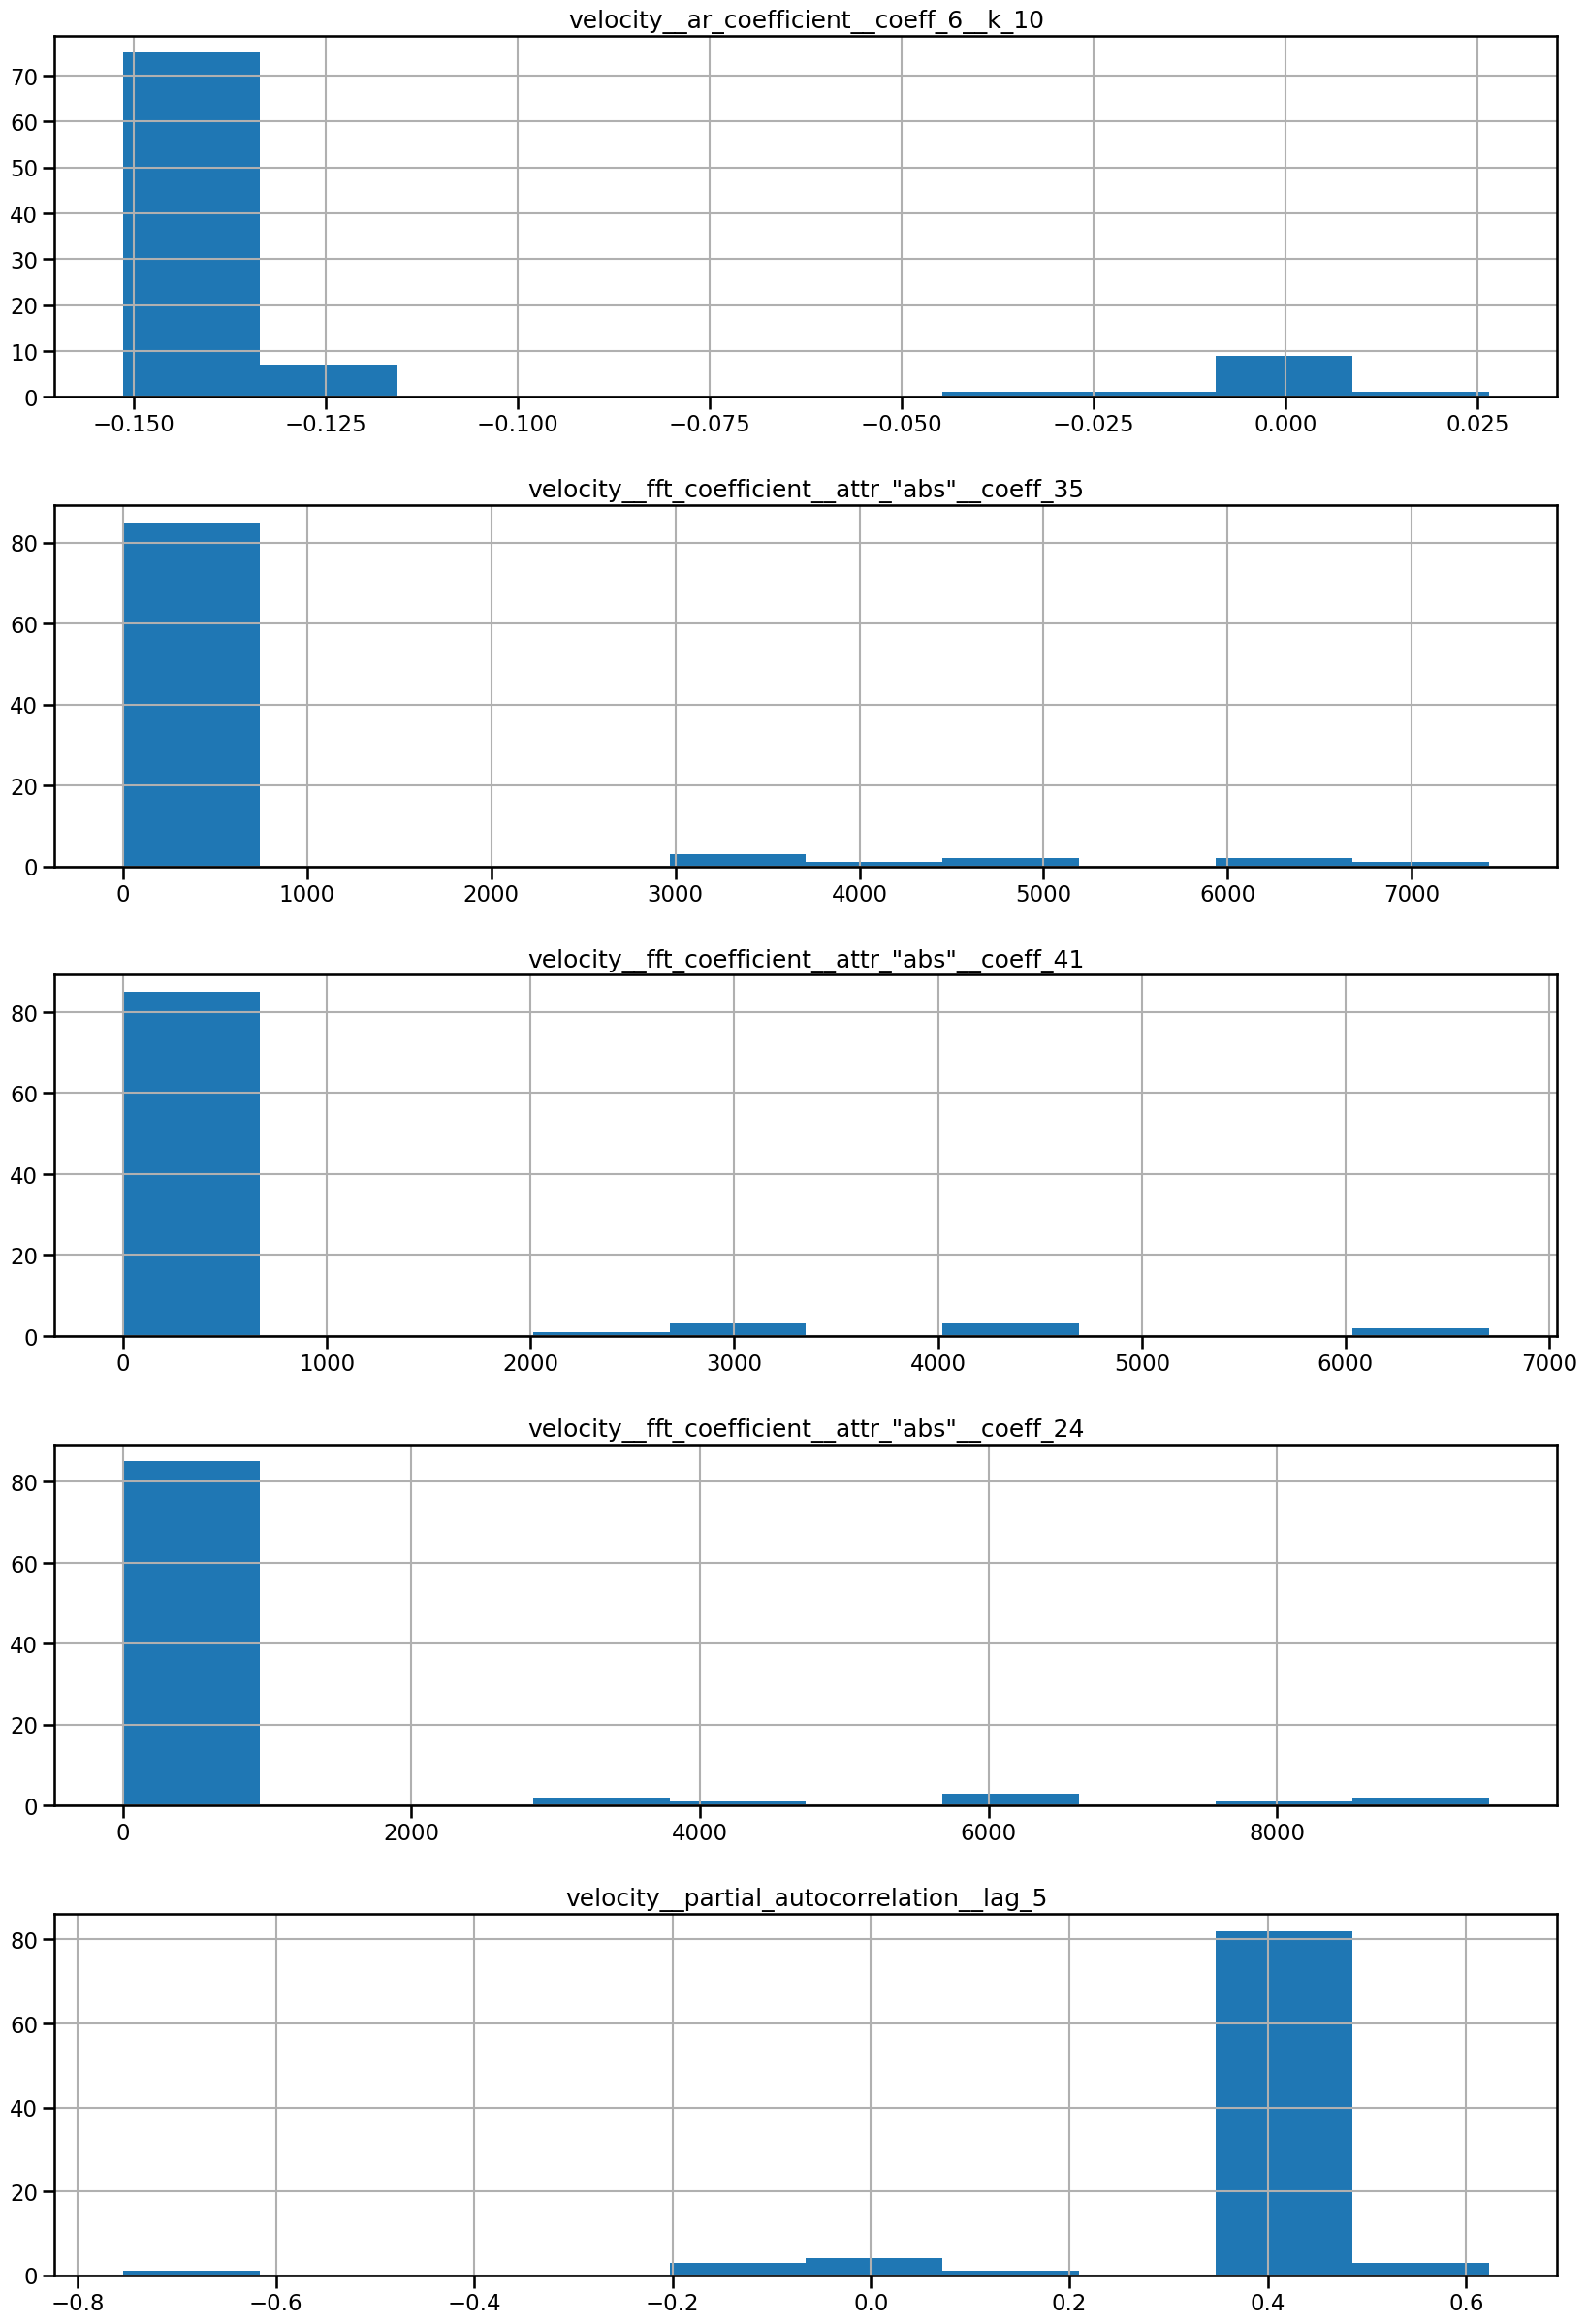

In [17]:
pruned_frame.hist(layout=(5,1), figsize=(20,30))
pruned_frame.describe()

We can see that most features are distributed with a heavy tail. We will try to use a cubic root transformation for some normalisation.

array([[<Axes: title={'center': 'velocity__ar_coefficient__coeff_6__k_10'}>],
       [<Axes: title={'center': 'velocity__fft_coefficient__attr_"abs"__coeff_35'}>],
       [<Axes: title={'center': 'velocity__fft_coefficient__attr_"abs"__coeff_41'}>],
       [<Axes: title={'center': 'velocity__fft_coefficient__attr_"abs"__coeff_24'}>],
       [<Axes: title={'center': 'velocity__partial_autocorrelation__lag_5'}>]],
      dtype=object)

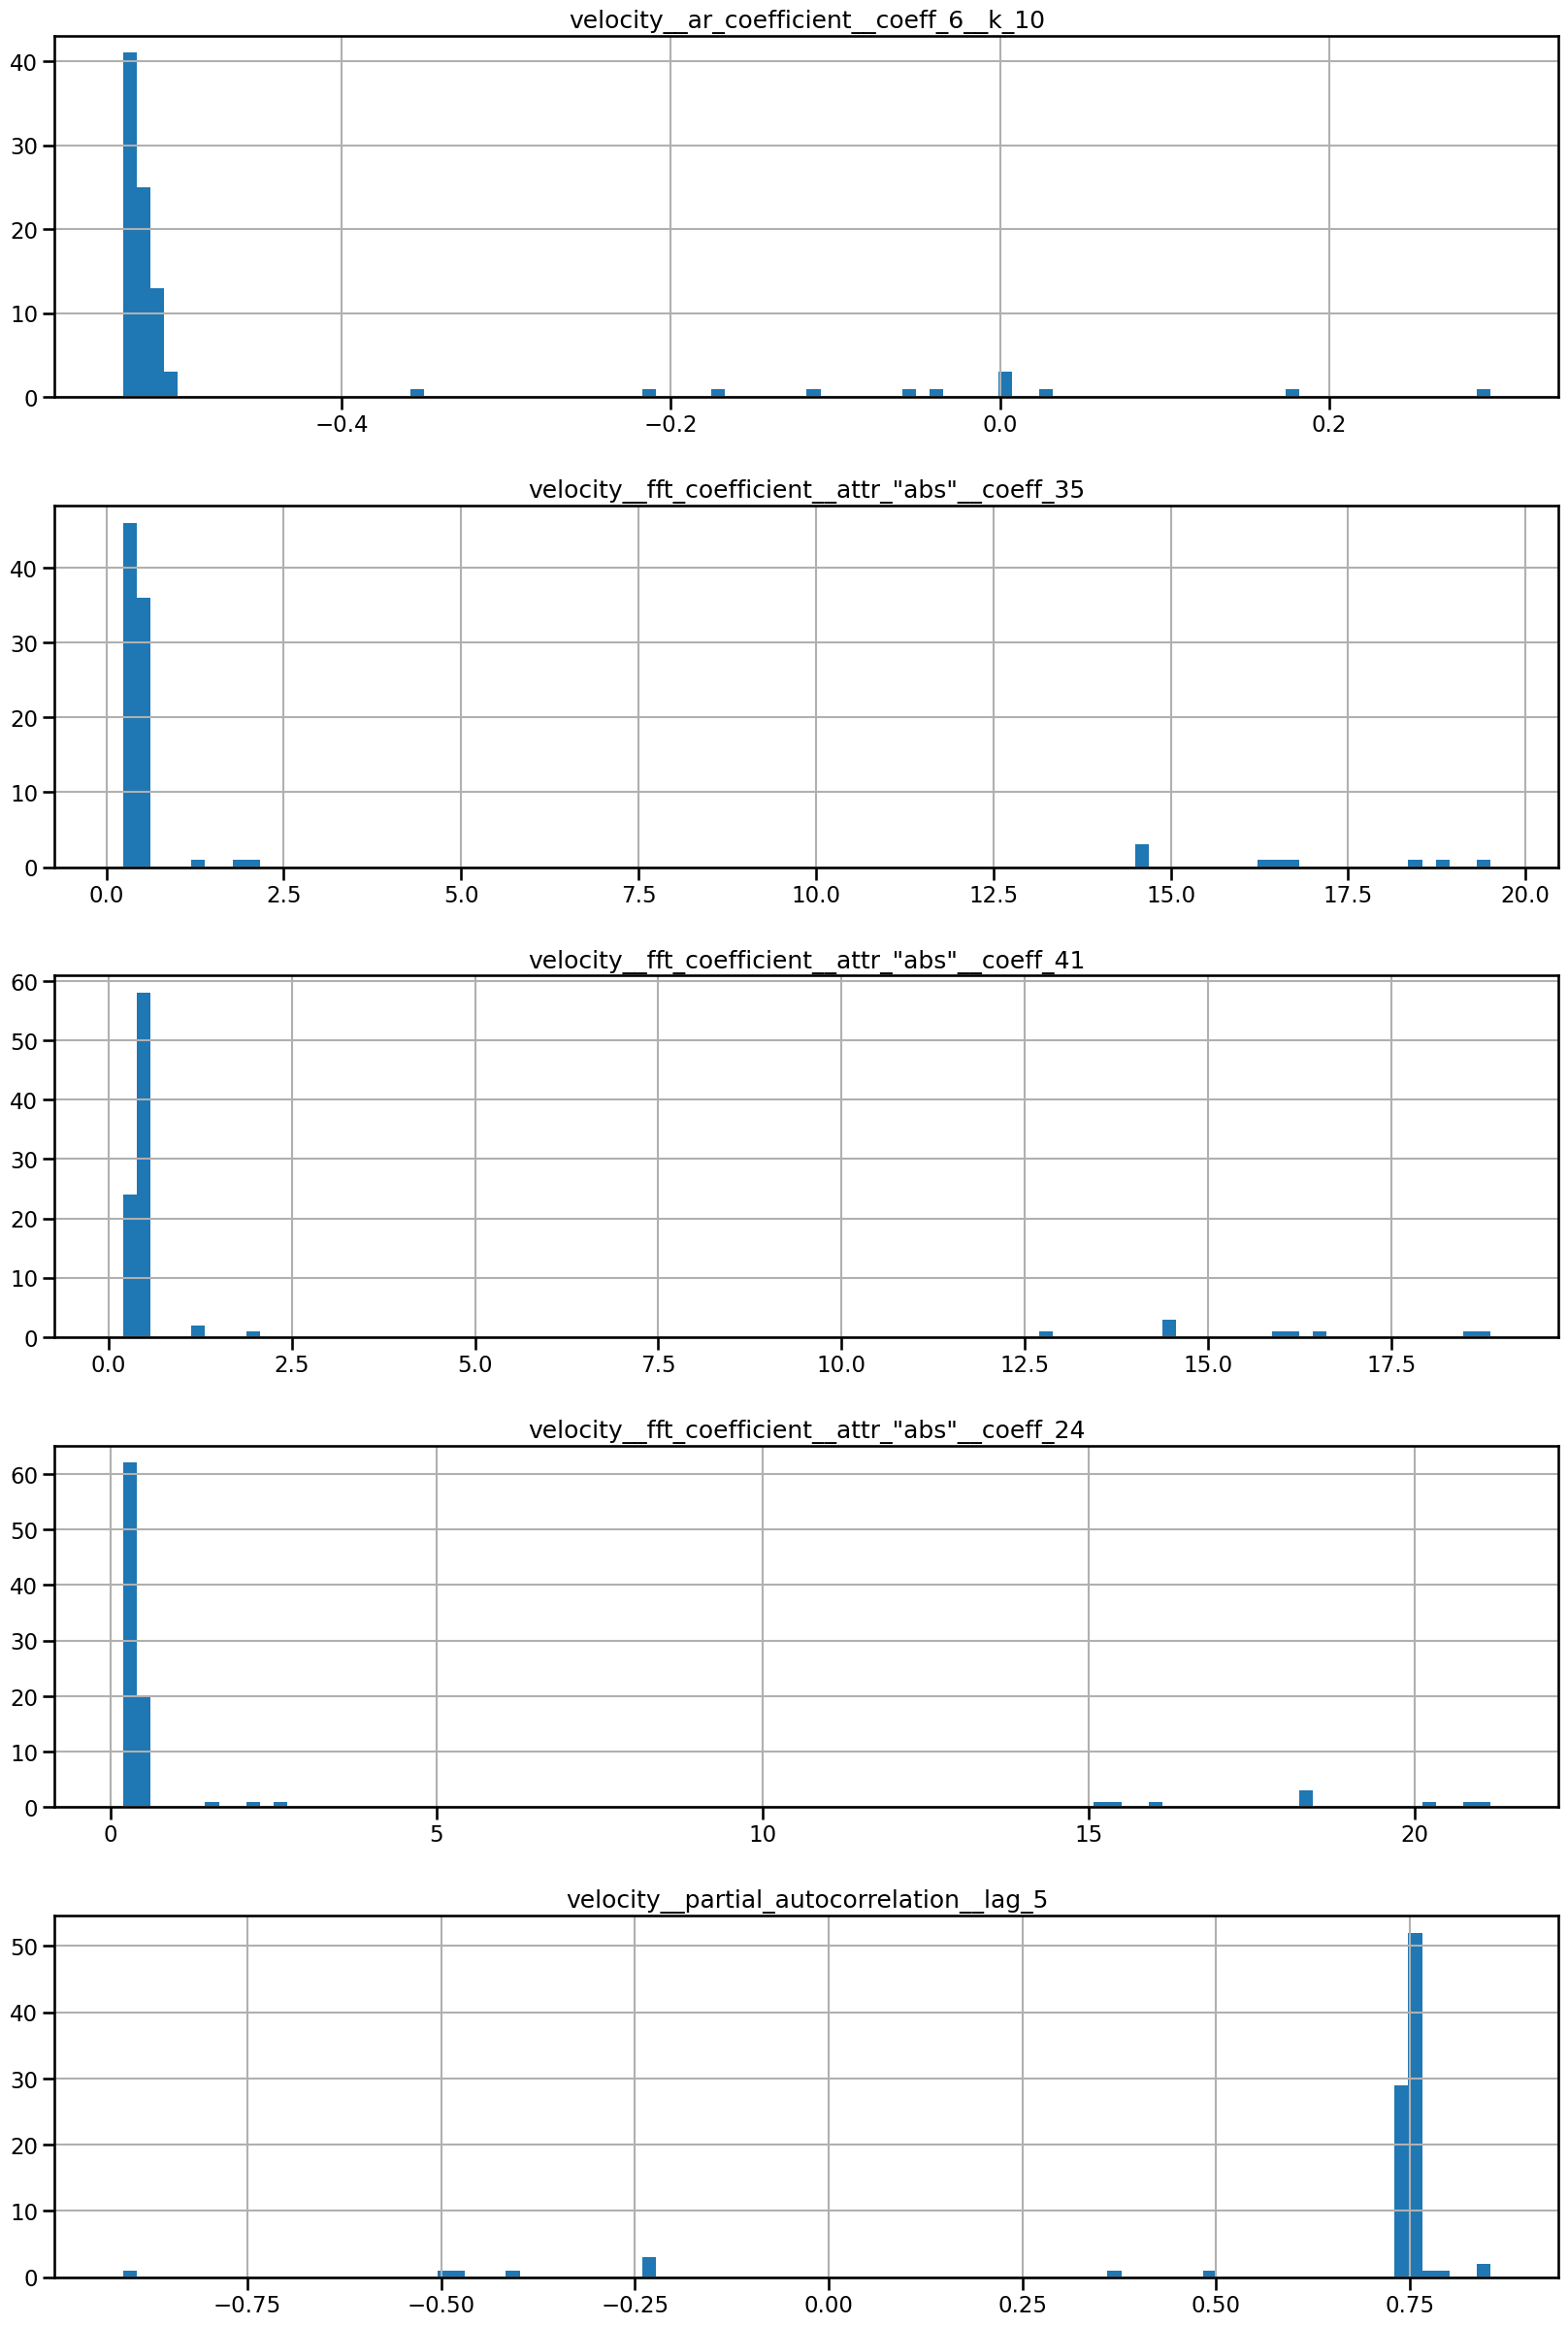

In [18]:
from sklearn.preprocessing import FunctionTransformer
sqrt_transformer = FunctionTransformer(np.cbrt,inverse_func=lambda X : X**3)
sqrt_arrays = sqrt_transformer.transform(pruned_frame)
pruned_frame2 = pd.DataFrame(sqrt_arrays, columns=pruned_frame.columns)
pruned_frame2.hist(bins = 100, layout=(5,1), figsize=(20,30))

array([[<Axes: title={'center': 'velocity__ar_coefficient__coeff_6__k_10'}>],
       [<Axes: title={'center': 'velocity__fft_coefficient__attr_"abs"__coeff_35'}>],
       [<Axes: title={'center': 'velocity__fft_coefficient__attr_"abs"__coeff_41'}>],
       [<Axes: title={'center': 'velocity__fft_coefficient__attr_"abs"__coeff_24'}>],
       [<Axes: title={'center': 'velocity__partial_autocorrelation__lag_5'}>]],
      dtype=object)

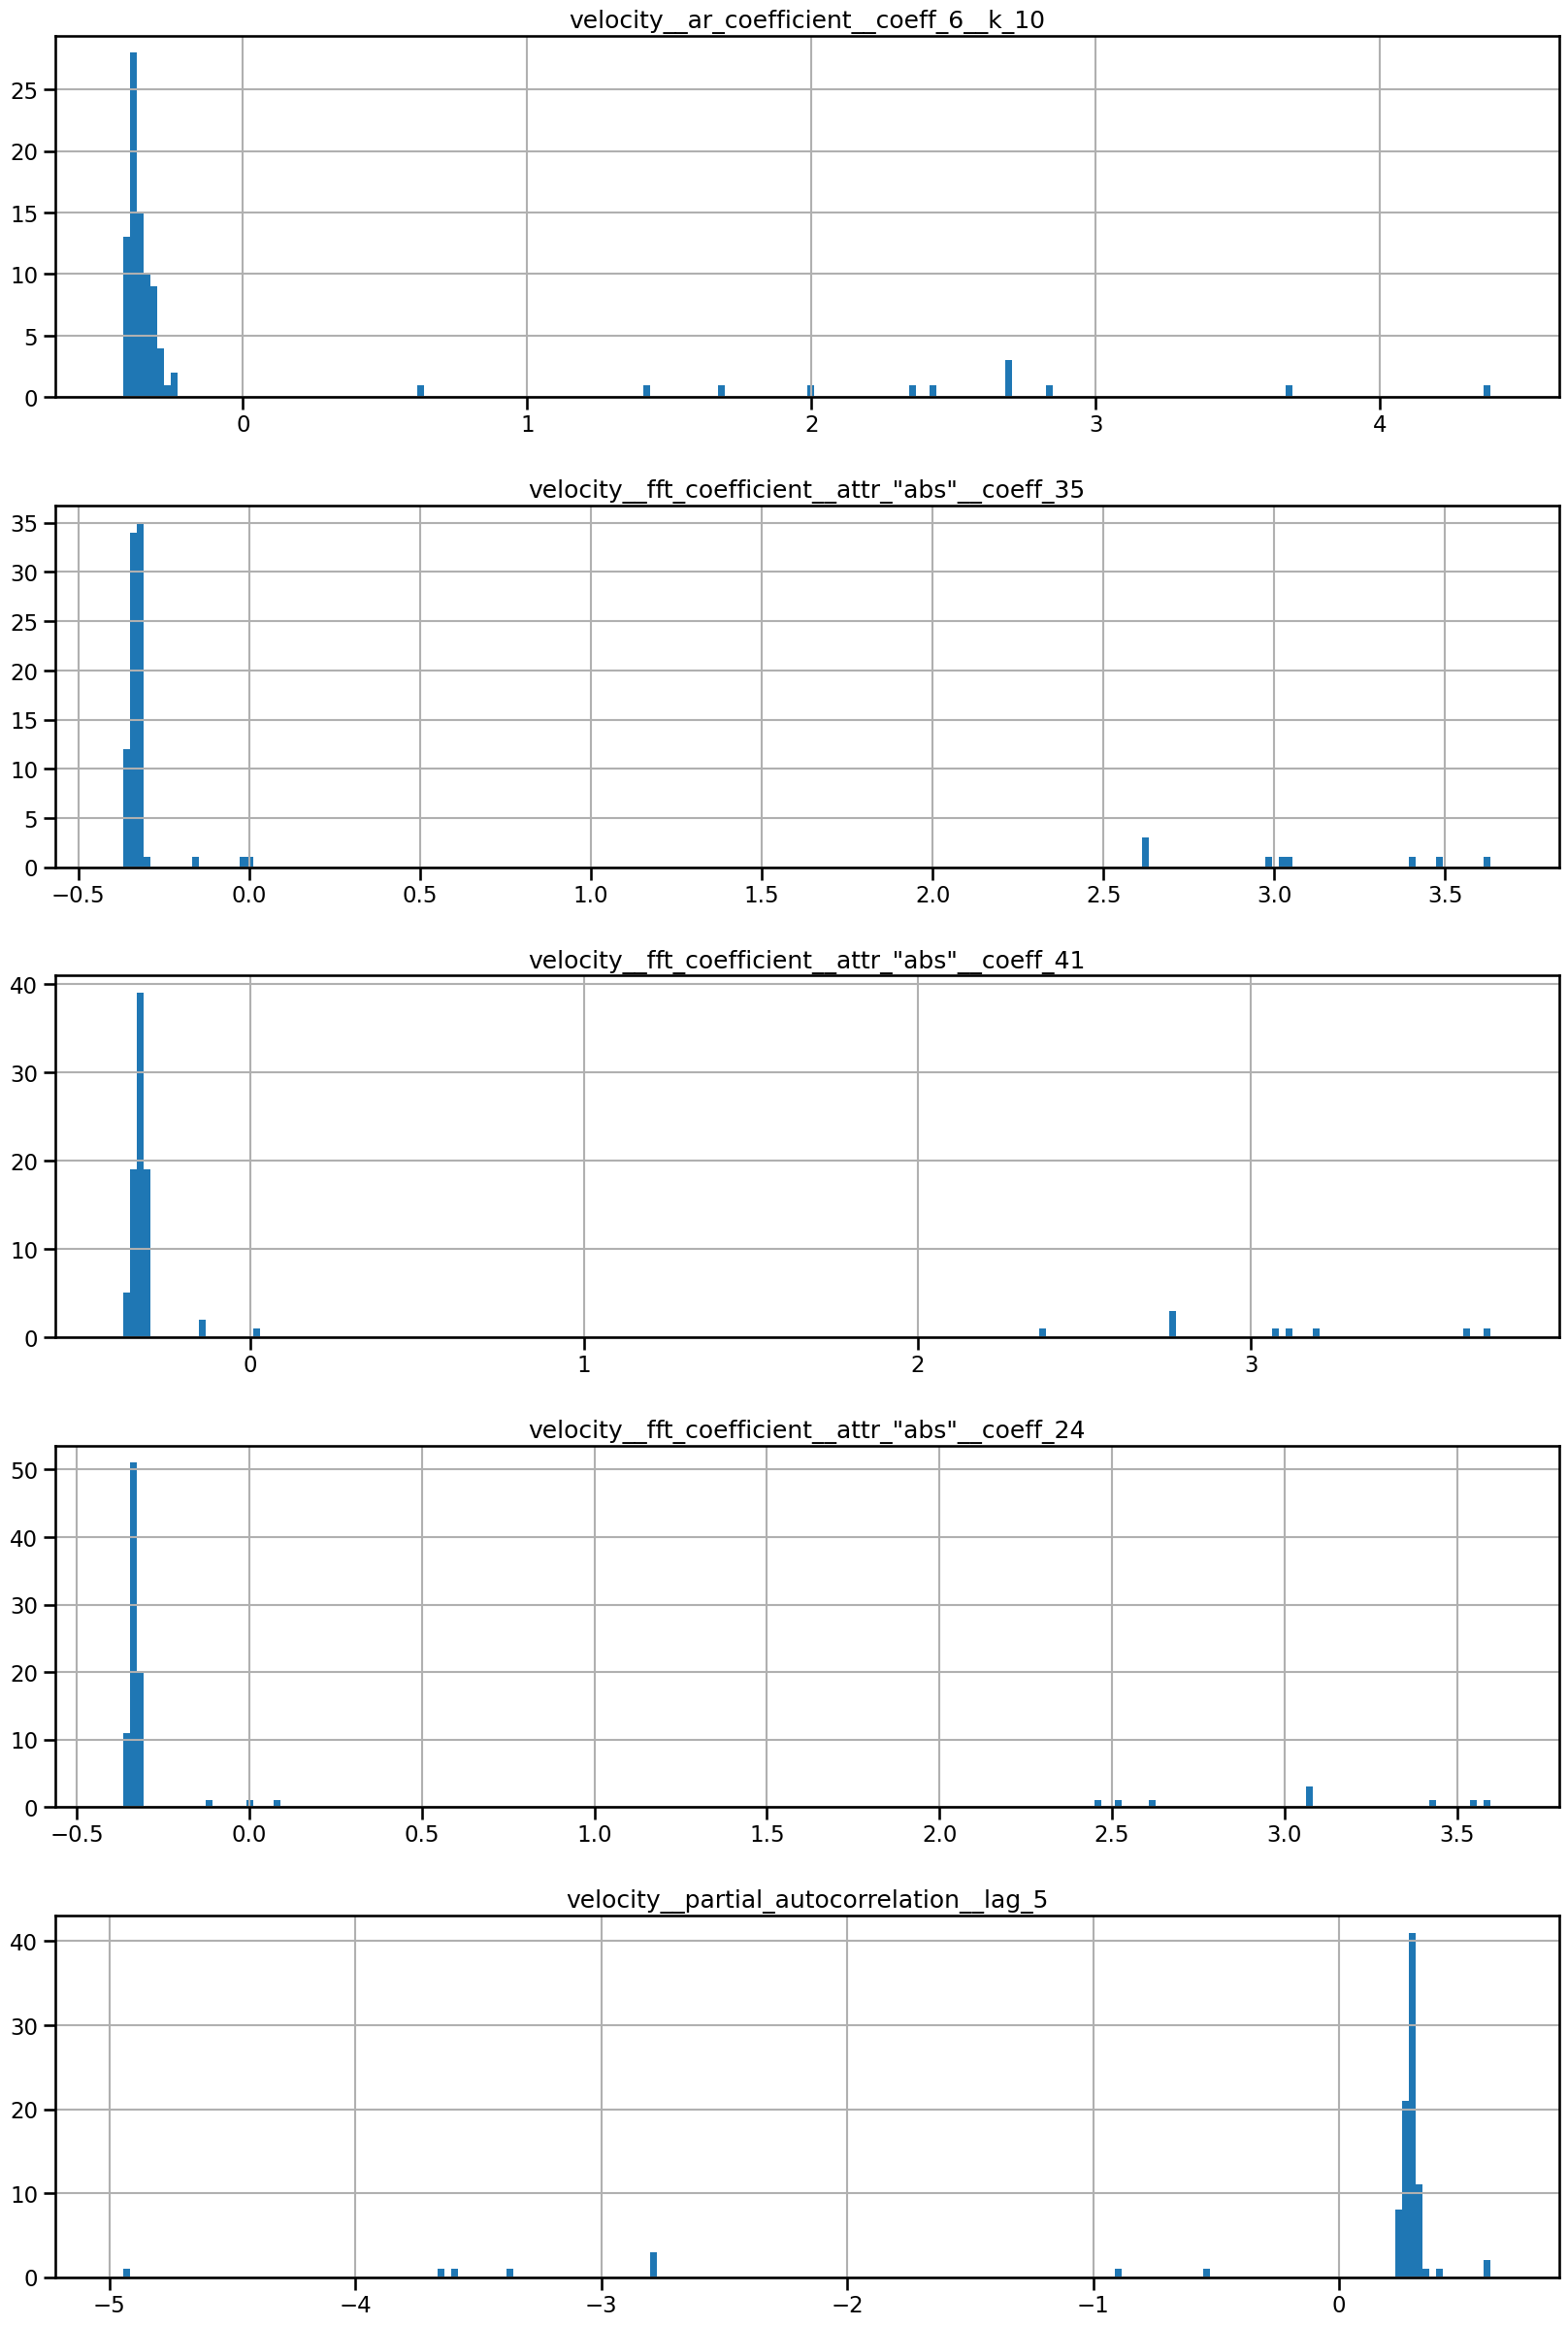

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_arrays = scaler.fit_transform(pruned_frame2)
pruned_scaled_frame = pd.DataFrame(scaled_arrays, columns=scaler.get_feature_names_out())
pruned_scaled_frame.hist(bins=200, layout=(5,1), figsize=(20,30))

In [20]:
pruned_scaled_frame.describe()

,velocity__ar_coefficient__coeff_6__k_10,"velocity__fft_coefficient__attr_""abs""__coeff_35","velocity__fft_coefficient__attr_""abs""__coeff_41","velocity__fft_coefficient__attr_""abs""__coeff_24",velocity__partial_autocorrelation__lag_5
count,9.400000e+01,9.400000e+01,9.400000e+01,9.400000e+01,9.400000e+01
mean,1.792302e-16,-8.267618e-18,-8.858162e-18,6.555040e-17,-1.213568e-16
std,1.005362e+00,1.005362e+00,1.005362e+00,1.005362e+00,1.005362e+00
min,-4.206141e-01,-3.685386e-01,-3.798342e-01,-3.656452e-01,-4.943273e+00
25%,-3.861548e-01,-3.399365e-01,-3.390020e-01,-3.382048e-01,2.676813e-01
50%,-3.605519e-01,-3.279479e-01,-3.253856e-01,-3.289921e-01,2.883944e-01
75%,-3.185432e-01,-3.176269e-01,-3.128758e-01,-3.225264e-01,3.035644e-01
max,4.388177e+00,3.632513e+00,3.717498e+00,3.596894e+00,6.160219e-01


In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_frame=pd.DataFrame(data=pca.fit_transform(pruned_scaled_frame), columns=["c1","c2","c3"])
pca.explained_variance_ratio_

array([0.93957404, 0.04918084, 0.00812316])

In [22]:
pca2 = pd.DataFrame(data=pca.transform(pruned_scaled_frame), columns=["c1","c2","c3"])
pca.explained_variance_ratio_

array([0.93957404, 0.04918084, 0.00812316])


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: C:\Users\JoshuaBraun\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


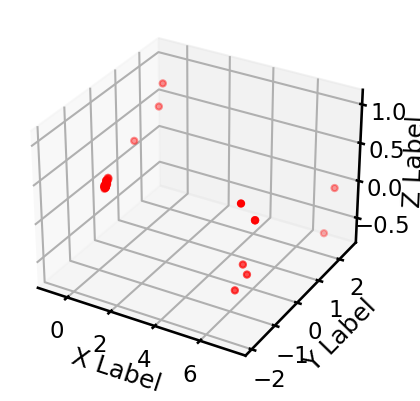

In [23]:
!pip install --upgrade nbformat
import plotly.express as px
x,y,z = pca_frame["c1"],pca_frame["c2"],pca_frame["c3"]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='r', marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

fig = px.scatter_3d(x=x, y=y, z=z)
fig.update_traces(marker=dict(size=5, opacity=0.15))
fig.show()


For a unsupervised anomaly detection task, observations beyond a certain Euclidean distanc can be labeled as anomalous

In the next step, we will try to evaluate our reduced feature dataset. There are a number of hyperparameters that can be set in our preprocessing
workflow so far, so we will need a form of benchmarking to decide on a desired combination. Therefore, we will take another batch of data from our sensors,
apply rolling windows comparable to the ones we took for our selection and label some instances as anomalies by using heuristics to supply a selection of supervised
classification algorithms with ground-truth values. We will use the scoring metrics of these fitted models on some test data derived from the same batch
to tweak our selection.

In [24]:
# The evaluation dataframe will consist of a window of 10 800 000 observations, aka. 3 hours
start_row = 7200001 #skipping the first 7200000 million used in the extraction phase
end_row = 13800001

# Calculate the number of rows to skip before the start_row
rows_to_skip = start_row - 1
# Read the specified subset of rows using Pandas
subset_df = pd.read_csv("C:\\Users\\JoshuaBraun\\Downloads\\Bamberg_DE1.csv", skiprows=rows_to_skip, nrows=end_row - start_row ,delimiter=";", decimal=",")
subset_df.columns =new_column_names_for_readability
# Now subset_df contains the specified range of rows from the CSV file
print(subset_df)
#subset_df = subset_df["DW01_velocity"

         ms_since_start  DW01_velocity   
0             7200000.0            0.0  \
1             7200001.0            0.0   
2             7200002.0            0.0   
3             7200003.0            0.0   
4             7200004.0            0.0   
...                 ...            ...   
6599995      13799995.0            0.0   
6599996      13799996.0            0.0   
6599997      13799997.0            0.0   
6599998      13799998.0            0.0   
6599999      13799999.0            0.0   

         DW01_position  DW01_Difference   
0           660.043063              0.0  \
1           660.043063              0.0   
2           660.043063              0.0   
3           660.043063              0.0   
4           660.043063              0.0   
...                ...              ...   
6599995     480.090467              0.0   
6599996     480.090467              0.0   
6599997     480.090467              0.0   
6599998     480.090467              0.0   
6599999     480.090467

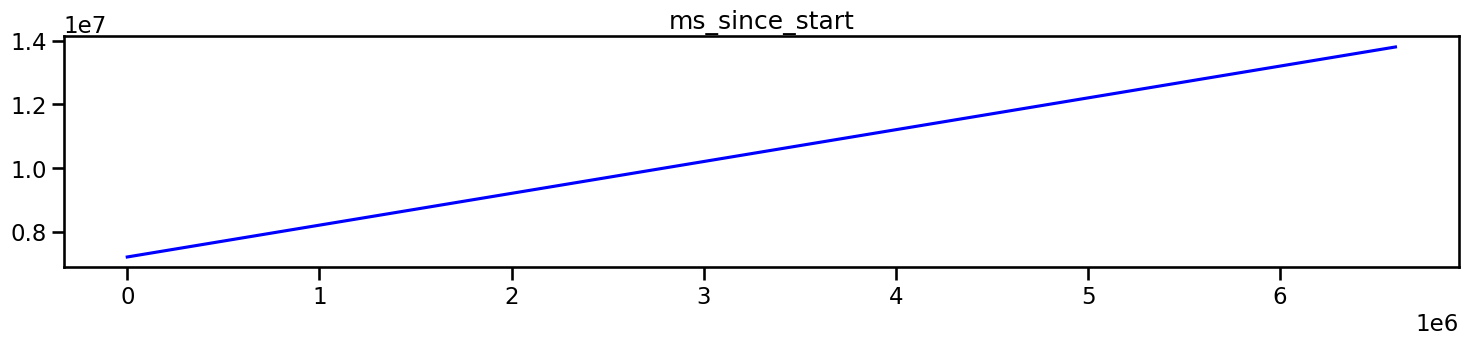

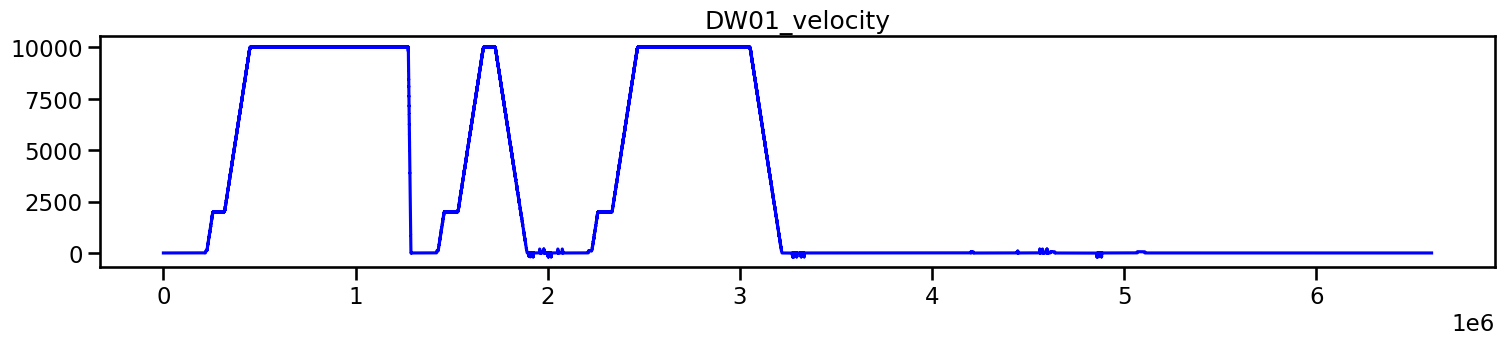

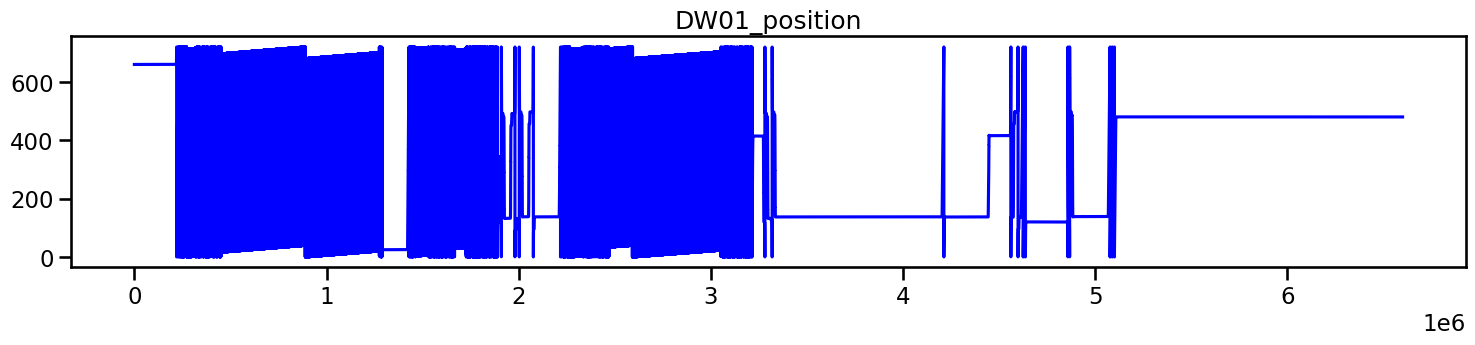

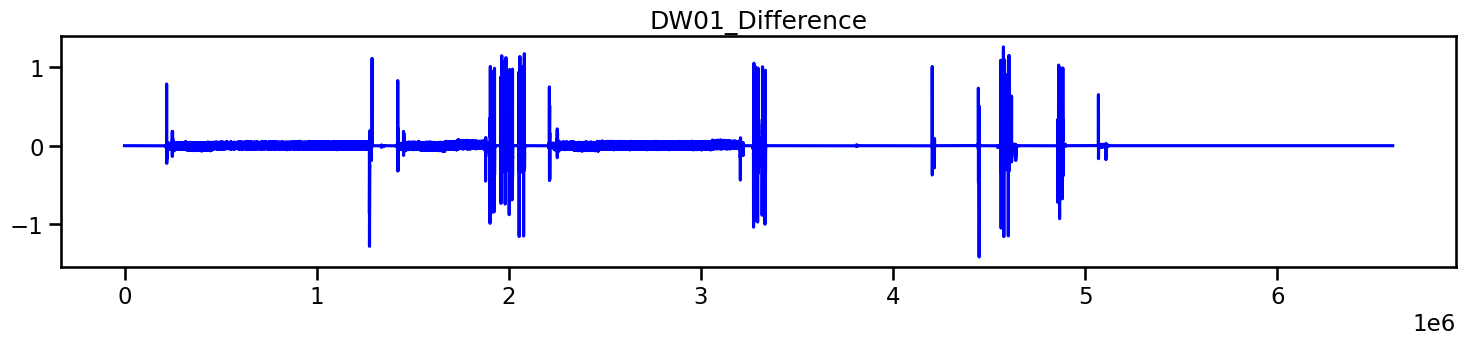

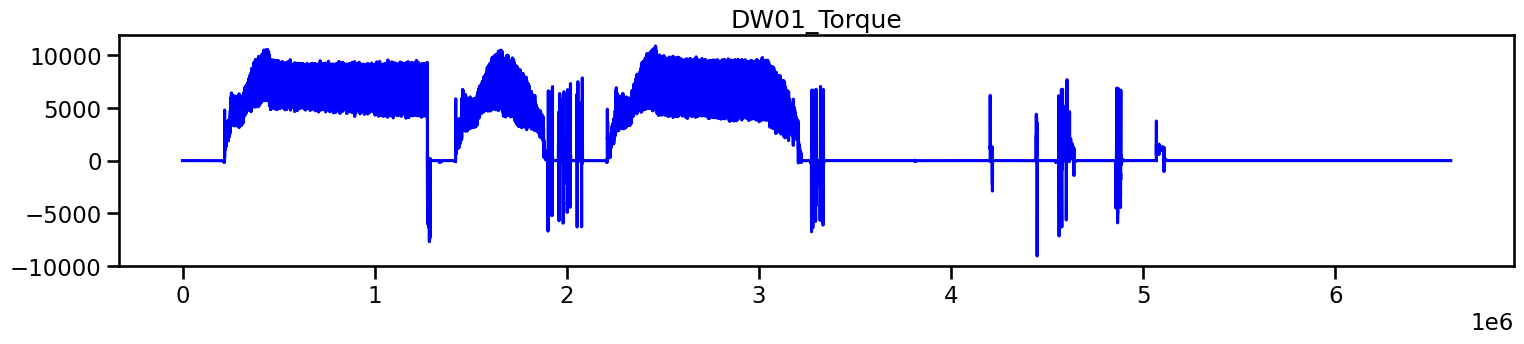

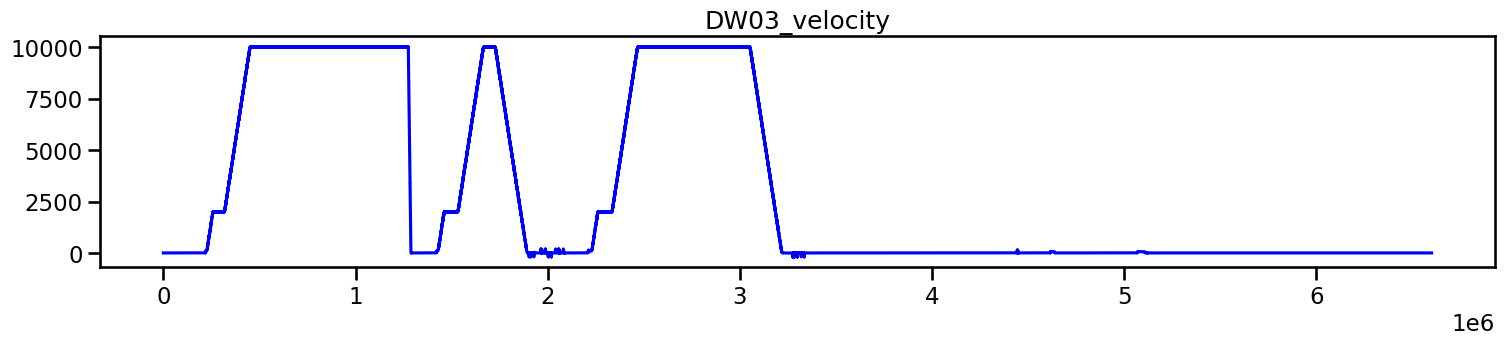

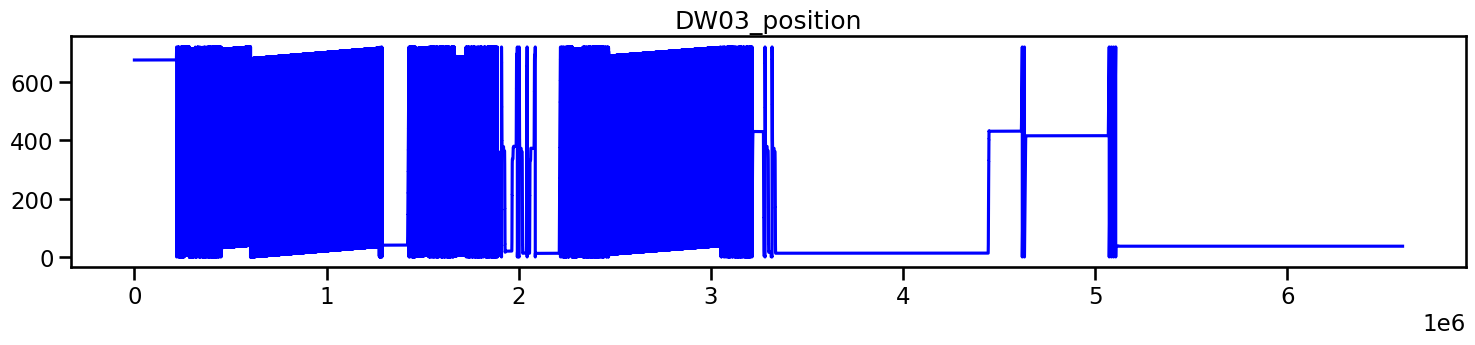

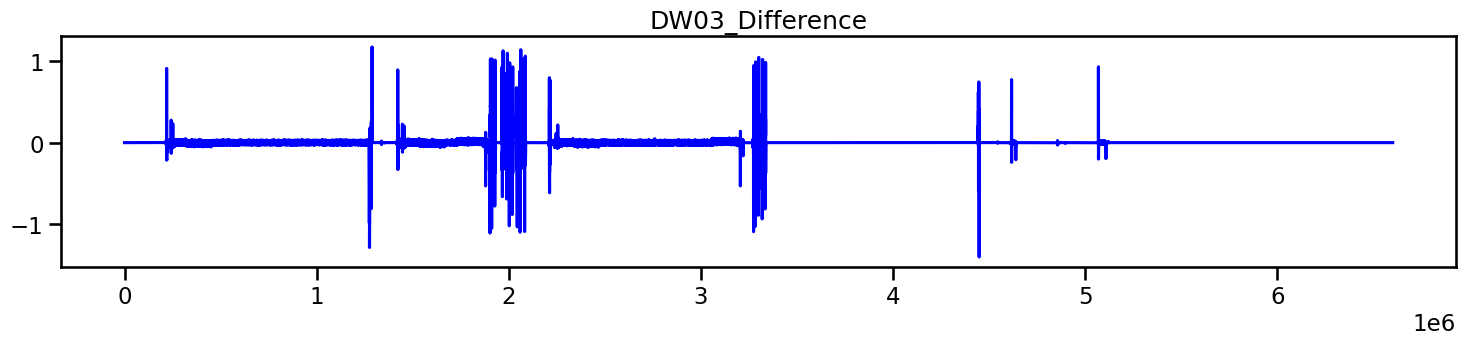

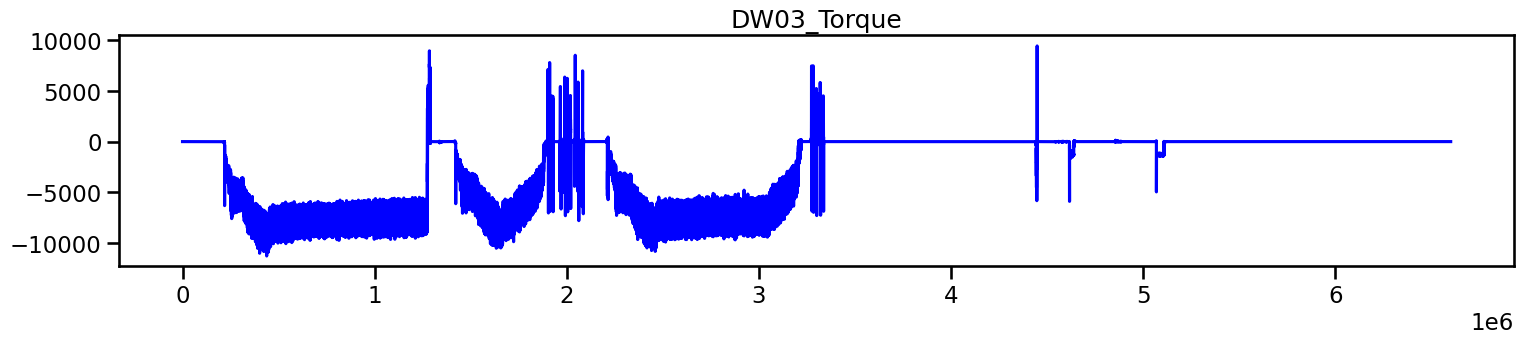

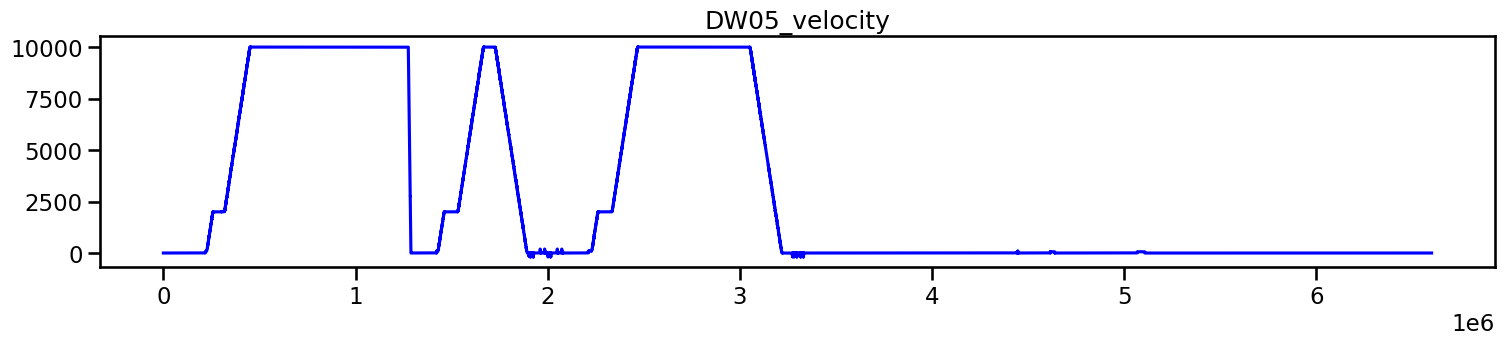

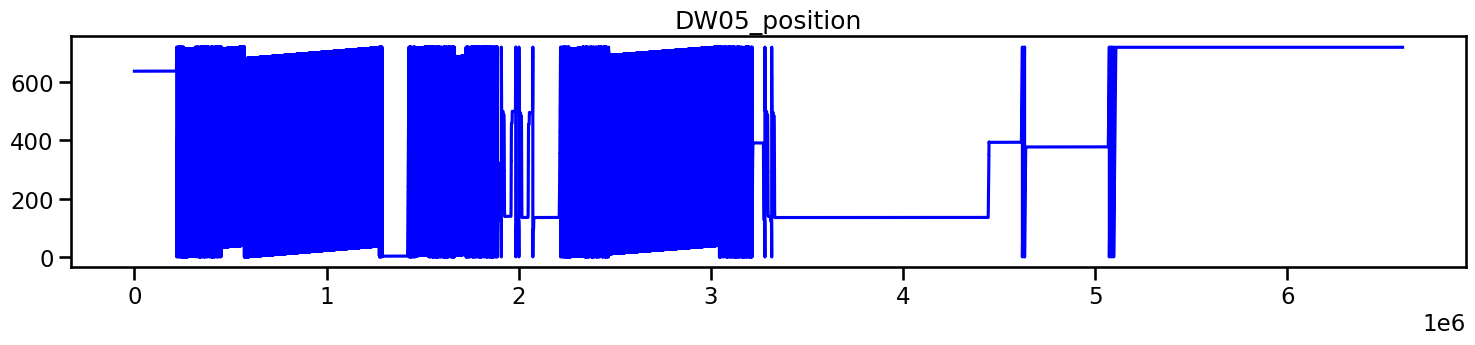

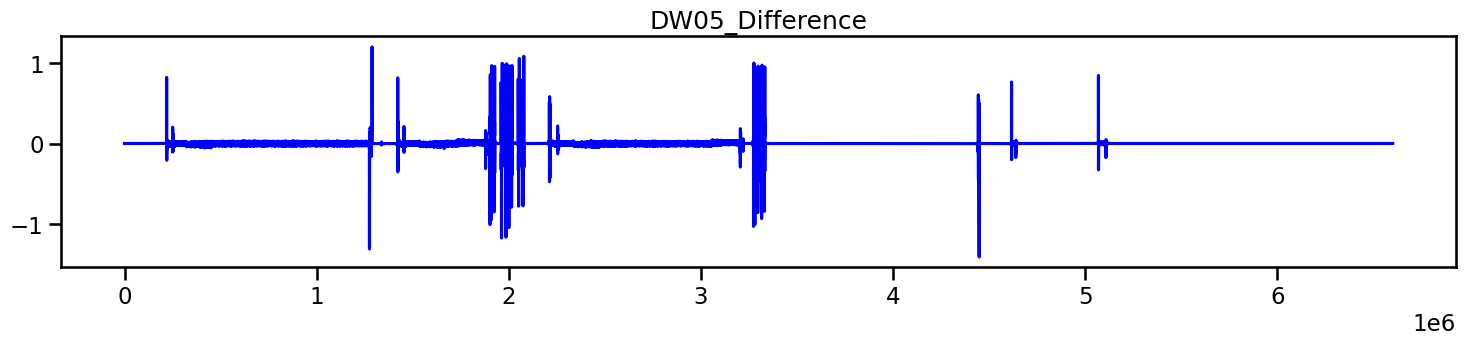

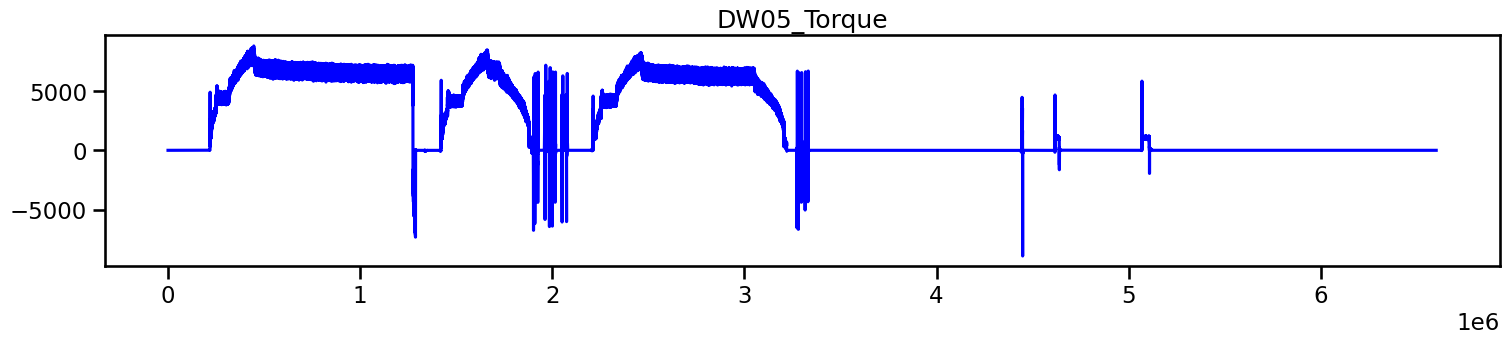

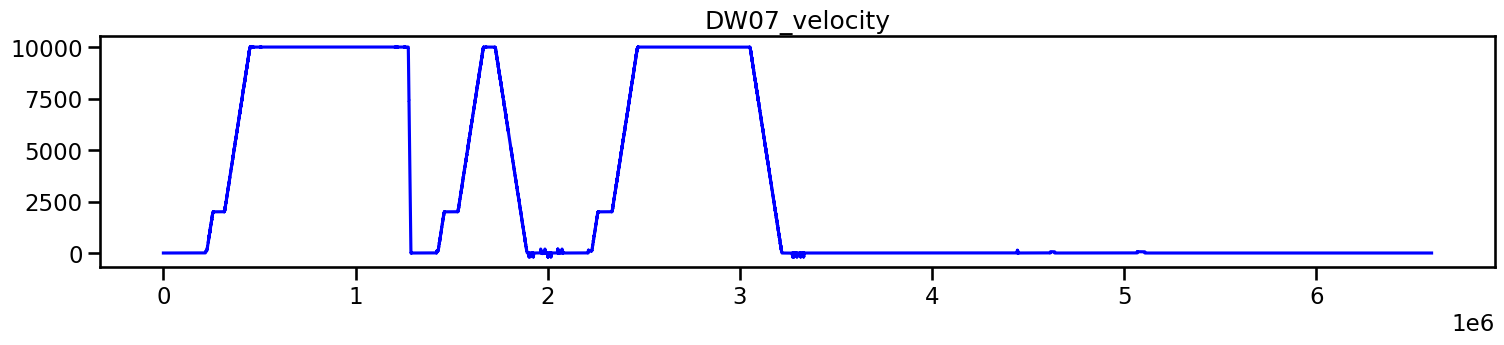

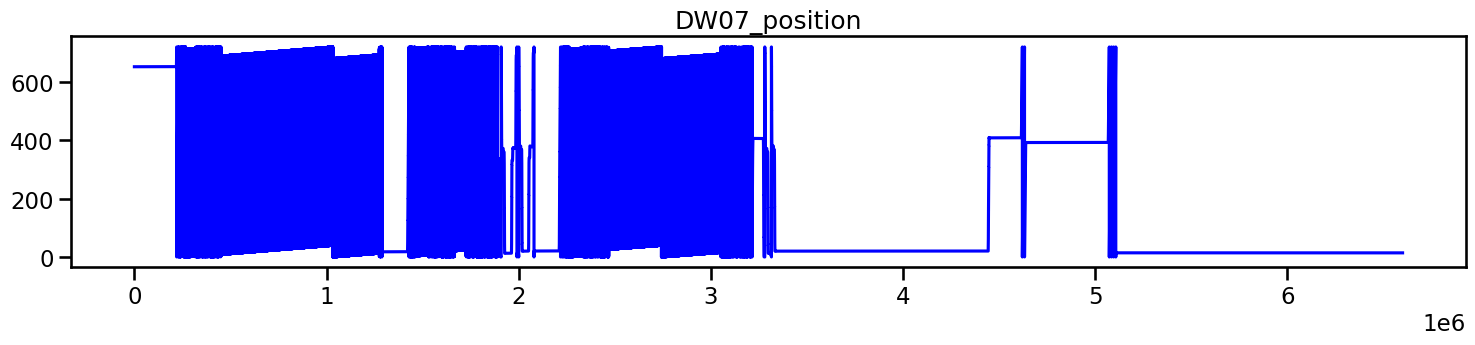

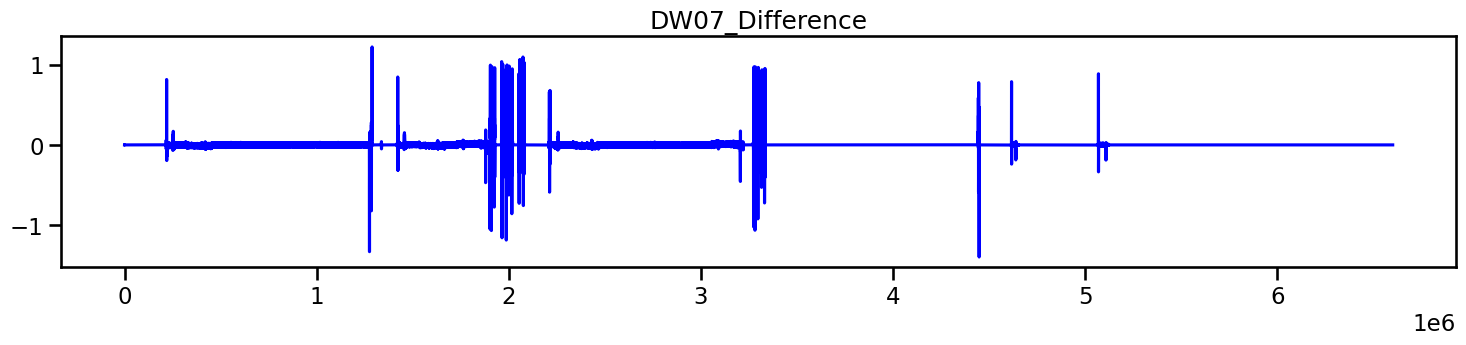

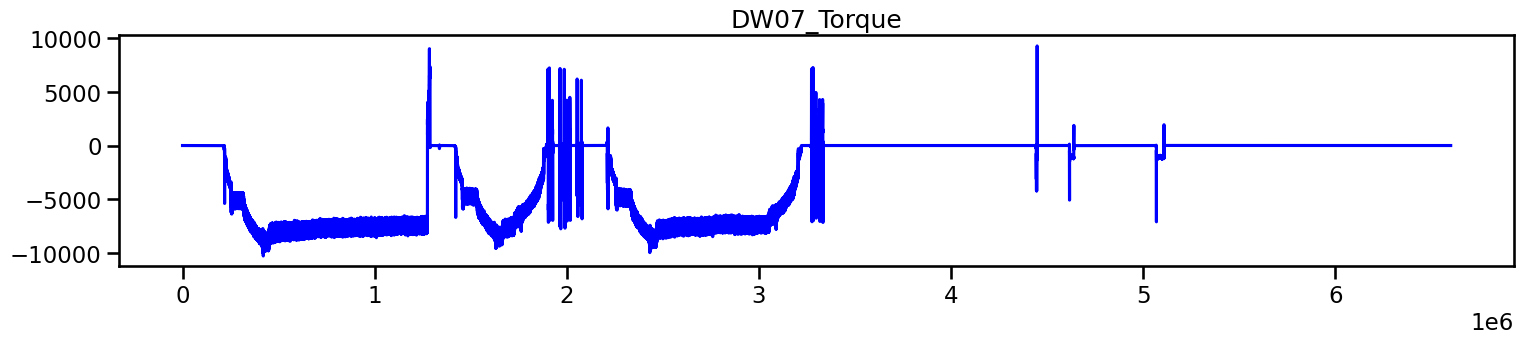

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
names=subset_df.columns

for name in names:
    sns.set_context('talk')
    _ = plt.figure(figsize=(18,3))
    _ = plt.plot(subset_df[name], color='blue')
    _ = plt.title(name)
    plt.show()

We will now iterate through the rolling windows, and label them as either anomalous or normal, based on the following heuristic rules.
A whole window will be labeled as anomalous if:
-It contains at least 10 data points that are more than 2 standard deviations away from the median(of the entire sensor-reading) -> outlier
-If the difference between a datapoint and it's neighbouring readings is more than 10 units -> spike
-If an entire window contains roughly identical and non-zero values e.g. the rounded range of window equals zero -> constant

In [26]:
def extract_and_label(col_to_pass,selected_feature_list, window_size=rolling_window_size):
    import re
    '''
    Disclaimer: This is a brutish function that will calculate a huge amount of features just to drop them again in favor of our very small
    subset. Sadly, extracting specific features based on a prior selection outside the tsfresh functionalities is very cumbersome.
    There will be a need for improving this function in the future
    '''
    n = len(col_to_pass)
    sensor_column =[col_to_pass[i:i+window_size] for i in range(0, n, window_size)]
    sensor_med = np.median(col_to_pass)
    sensor_std = np.std(col_to_pass)
    label_list = []
    #regex to identify how we have to name our column later on
    re_pat = r"^(.*?)_"

    # Search for the pattern in the first string
    col_name = re.search(re_pat, selected_feature_list[0])

    col_name = col_name.group(1)
    col_name_for_frame = [col_name]
    #The labeling
    for window in sensor_column: #iterate through the windows
        already_labeled = False
        if np.mean(window) != 0 and np.round(range_of_vals(window),1) == 0: #check for constant windows
            label_list.append("anomalous")
            continue
        for index,value in enumerate(window):#iterate through the values
            try:
                if abs(value) > sensor_med + 2 * sensor_std: #check for outlier
                    label_list.append("anomalous")
                    already_labeled=True
                    break
                elif abs(window[index+1]-value) > 10: #check for spike
                    label_list.append("anomalous")
                    already_labeled=True
                    break
            except KeyError:
                    break
        if already_labeled:
            continue
        label_list.append("normal")

    #Extracting and selecting desired features
    extraction_frame = pd.DataFrame({col_name:col_to_pass})
    _ = extraction_frame.index // 12000 #size of rolling windows = 12 000
    extraction_frame['grouping'] = _

    feature_frame = extract_features(extraction_frame, column_id="grouping", default_fc_parameters=fcp_settings)

    final_frame = feature_frame[selected_feature_list]
    final_frame["labels"]=label_list

    return final_frame

col = subset_df["DW01_velocity"]
labeled_frame = extract_and_label(col, DW01_features)

Feature Extraction: 100%|██████████| 20/20 [18:57<00:00, 56.87s/it]  
C:\Users\JoshuaBraun\AppData\Local\Temp\ipykernel_17480\3073659189.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



labels
normal       401
anomalous    149
Name: count, dtype: int64


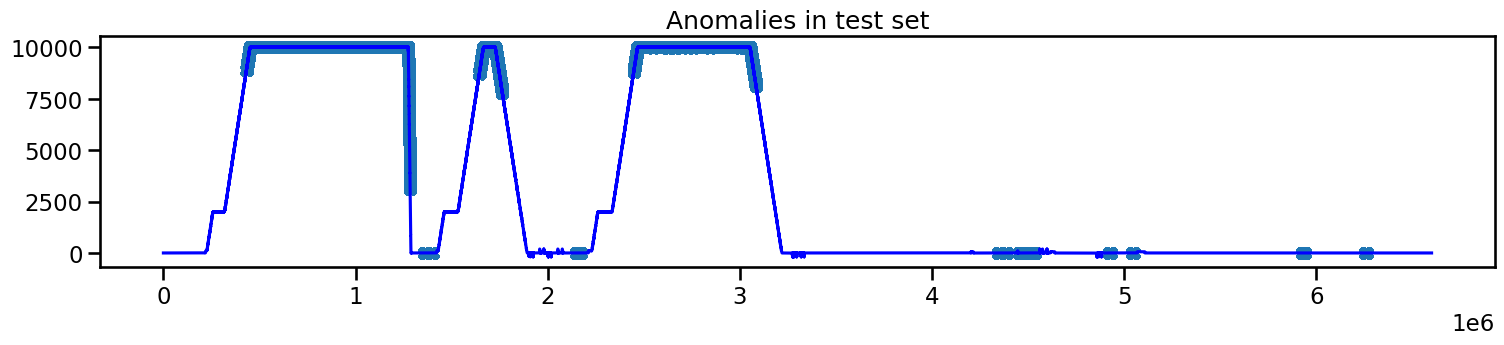

In [27]:
labeled_frame = labeled_frame.dropna(axis=0)
print(labeled_frame["labels"].value_counts())
# extend labels to subset list
labels_for_plot = [value for value in labeled_frame["labels"] for _ in range(12000)]
subset_df["labels"] = labels_for_plot

anomalous_frame = subset_df[subset_df['labels']=='anomalous']
# Extract the names of the numerical columns


_ = plt.figure(figsize=(18,3))
_ = plt.plot(anomalous_frame["DW01_velocity"], linestyle='none', marker='X')
_ = plt.plot(subset_df["DW01_velocity"], color='blue')
_ = plt.title("Anomalies in test set")
plt.show()


We will track the experiments using ML Flow

In [28]:
import mlflow
experiment_ID = mlflow.set_experiment("Feature Selection Validation")

In [29]:
!mlflow ui

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit


def mlflow_track_threefold_run(ex_id,run_name,param_dict, dataset,**kwargs):
    '''
    Custom function to quickly generate a "parent run" consisting of three separate model evaluations.
    Important: An experiment to store the generated metrics has to be created beforehand!
    Optionally, the dataset can be scaled and transformed via PCA. Up to two scalers (one custom, one standard)
    if named correctly as "customscaler" and "standardscaler" as well as a PCA-Transformer can be supplied as kwargs
    '''

    frame_copy = dataset.copy()
    label_encoder = LabelEncoder()
    y_enc = label_encoder.fit_transform(frame_copy.pop("labels")) #correctly encode labels

    tscv = TimeSeriesSplit(n_splits=5) # will use time series splitting for cross-validation

    # check for kwargs
    statement_pca = False
    if 'customscaler' in kwargs: # scaler1 first
        customscaler = kwargs['customscaler']
        sqrt_arrays_ = customscaler.transform(frame_copy)
        frame_copy = pd.DataFrame(sqrt_arrays_, columns=frame_copy.columns)
    if 'standardscaler' in kwargs: # scaler1 first
        standardscaler = kwargs['standardscaler']
        sqrt_arrays_ = standardscaler.transform(frame_copy)
        frame_copy = pd.DataFrame(sqrt_arrays_, columns=scaler.get_feature_names_out())
    if 'PCA' in kwargs:
        pca_ = kwargs["PCA"]
        frame_copy = pd.DataFrame(data=pca_.transform(frame_copy), columns=["c1","c2","c3"])
        statement_pca = True


    overall_precision = [] #create lists for overall metric calculations of the parent run
    overall_accuracy = []
    overall_recall = []
    nans = 0

    with mlflow.start_run(          #starting a new parent run
        run_name=run_name,
        experiment_id=ex_id,
        description="This run will evaluate three different models and average their scoring results"
    ) as parent_run:
        mlflow.log_params(param_dict)               #logging parent run characteristics

        with mlflow.start_run(
            run_name="RF_run",
            experiment_id=experiment_ID,
            description="Using a Random-Forest-Model",
            nested=True,
        ) as child_run:
            mlflow.sklearn.autolog()
            est1=RandomForestClassifier()
            cv_results=cross_validate(est1,frame_copy,y_enc,cv=tscv, scoring=["precision","accuracy","recall"])
            # perform eval
            nan_count = np.sum(np.isnan(cv_results["test_precision"]))
            nans += nan_count
            prec =  round(np.mean(cv_results["test_precision"][~np.isnan(cv_results["test_precision"])]),2)
            accu =  round(np.mean(cv_results["test_accuracy"][~np.isnan(cv_results["test_accuracy"])]),2)
            reca =  round(np.mean(cv_results["test_recall"][~np.isnan(cv_results["test_recall"])]),2)
            metrics = {"Avg_precision": prec, "Avg_accuracy" : accu, "Avg_recall": reca}
            mlflow.log_metrics(metrics)
            # save metrics
            overall_precision.append(prec)
            overall_accuracy.append(accu)
            overall_recall.append(reca)


        with mlflow.start_run(
            run_name="SVC_RUN",
            experiment_id=experiment_ID,
            description="Using a linear Support Vector Machine",
            nested=True,
        ) as child_run2:
            mlflow.sklearn.autolog()
            est2=LinearSVC(random_state=42, max_iter=40000)
            cv_results=cross_validate(est2,frame_copy,y_enc,cv=tscv, scoring=["precision","accuracy","recall"])
            nan_count = np.sum(np.isnan(cv_results["test_precision"]))
            nans += nan_count
            prec =  round(np.mean(cv_results["test_precision"][~np.isnan(cv_results["test_precision"])]),2)
            accu =  round(np.mean(cv_results["test_accuracy"][~np.isnan(cv_results["test_accuracy"])]),2)
            reca =  round(np.mean(cv_results["test_recall"][~np.isnan(cv_results["test_recall"])]),2)
            metrics = {"Avg_precision": prec, "Avg_accuracy" : accu, "Avg_recall": reca}
            mlflow.log_metrics(metrics)
            if nan_count > 0:
                mlflow.set_tag("nan",nan_count)
            #save 'em
            overall_precision.append(prec)
            overall_accuracy.append(accu)
            overall_recall.append(reca)

        with mlflow.start_run(
            run_name="Log_Reg_Run",
            experiment_id=experiment_ID,
            description="Using a logistic regression",
            nested=True,
        ) as child_run3:
            mlflow.sklearn.autolog()
            est3=LogisticRegression(solver="saga", max_iter=40000)
            cv_results=cross_validate(est3,frame_copy,y_enc,cv=tscv, scoring=["precision","accuracy","recall"])
            nan_count = np.sum(np.isnan(cv_results["test_precision"]))
            nans += nan_count
            prec =  round(np.mean(cv_results["test_precision"][~np.isnan(cv_results["test_precision"])]),2)
            accu =  round(np.mean(cv_results["test_accuracy"][~np.isnan(cv_results["test_accuracy"])]),2)
            reca =  round(np.mean(cv_results["test_recall"][~np.isnan(cv_results["test_recall"])]),2)
            metrics = {"Avg_precision": prec, "Avg_accuracy" : accu, "Avg_recall": reca}
            mlflow.log_metrics(metrics)
            if nan_count > 0:
                mlflow.set_tag("nan",nan_count)
            # save metrics
            overall_precision.append(prec)
            overall_accuracy.append(accu)
            overall_recall.append(reca)

        mlflow.log_metrics({"Avg_precision": np.mean(overall_precision), "Avg_accuracy" : np.mean(overall_accuracy), "Avg_recall": np.mean(overall_recall)})
        if nans > 0:
            mlflow.set_tag("Non-convergent models:", nans)

        if statement_pca:
            mlflow.log_metric("PCA preserved variance",np.sum(pca_.explained_variance_ratio_))

est3=LogisticRegression(solver="saga", max_iter=10000)
label_encoder = LabelEncoder()
y_ = label_encoder.fit_transform(labeled_frame["labels"])
frame_copy = labeled_frame.drop("labels", axis=1)
tscv = TimeSeriesSplit(n_splits=5)
cv_results=cross_validate(est3,frame_copy,y_,cv=tscv, scoring=["precision","accuracy","recall"])
nan_count = np.sum(np.isnan(cv_results["test_precision"]))
#prec =  round(np.mean(cv_results[~np.isnan(cv_results["test_precision"])]),2)

data2 = cv_results["test_precision"]

data = np.array([4, np.nan, 6, np.nan, 10, 11, 14, 19, 22])
print(type(data))
print(type(data2))
#define new array of data with nan values removed
new_data = data[~np.isnan(data)]
new_data2 = np.mean(data2[~np.isnan(data2)])
print(new_data)
print(new_data2)

first_dict = {"Test run": "Ok, let's go"}
mlflow_track_threefold_run(experiment_ID,"My first run", first_dict,labeled_frame,customscaler=sqrt_transformer,standardscaler=scaler,PCA=pca)

Tracking is now possible via MLFlow UI